In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import r2_score
from torch.utils.tensorboard import SummaryWriter

In [2]:
path = 'C:/Users/user/Desktop/Spectr/scaled_data_reduce_10nm_step/'

Загрузка данных **y**

In [3]:
y_data = pd.read_csv(path + 'y_data.csv')
y = y_data.values

In [4]:
y_data

,pH(H2O),P,N,K,OC,CaCO3
0,7.16,28.8,6.9,235.0,77.2,89
1,7.16,28.8,6.9,235.0,77.2,89
2,6.87,19.2,4.2,42.6,34.2,7
3,6.87,19.2,4.2,42.6,34.2,7
4,7.16,22.6,3.6,17.9,35.1,44
...,...,...,...,...,...,...
21940,5.83,73.0,7.5,350.4,78.0,1
21941,7.52,20.2,2.4,316.2,19.8,47
21942,7.52,20.2,2.4,316.2,19.8,47
21943,6.48,40.7,2.9,304.1,25.8,1


Стандартизация набора данных

In [5]:
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y)
print(y_scaled.shape)

(21945, 6)


Данные без нормализации!!!

In [6]:
y_tensor = torch.Tensor(y_scaled)

Загрузка данных **x**

In [7]:
X_scaled = np.load(path + 'X_scaled.npy')
X1_scaled = np.load(path + 'X1_scaled.npy')
#X2_scaled = np.load(path + 'X2_scaled.npy')
X_dwt0_scaled = np.load(path + 'X_dwt0_scaled.npy')
X_dwt1_scaled = np.load(path + 'X_dwt1_scaled.npy')

In [8]:
X1_scaled.shape

(21945, 210)

In [9]:
X_scaled = X_scaled[:,::2]

In [10]:
n = 131

In [11]:
X_combined_scaled = torch.stack([torch.Tensor(X_scaled[:,:n]), torch.Tensor(X1_scaled[:,:n]), torch.Tensor(X_dwt0_scaled[:,:n]), torch.Tensor(X_dwt1_scaled[:,:n])], dim=2)

In [12]:
X_combined_scaled.shape

torch.Size([21945, 131, 4])

In [13]:
y_tensor.shape

torch.Size([21945, 6])

Разделение набора для тренировки, валидации и теста

In [14]:
# Разделение на обучающий, валидационный и тестовый наборы
X_train_tensor, X_temp_tensor, y_train_tensor, y_temp_tensor = train_test_split(X_combined_scaled, y_tensor, test_size=0.3, random_state=42)
X_valid_tensor, X_test_tensor, y_valid_tensor, y_test_tensor = train_test_split(X_temp_tensor, y_temp_tensor, test_size=0.5, random_state=42)

print(X_train_tensor.shape)
print(X_valid_tensor.shape)

torch.Size([15361, 131, 4])
torch.Size([3292, 131, 4])


In [15]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.LeakyReLU(0.01)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.LeakyReLU(0.01)
        self.conv3 = nn.Conv1d(out_channels, out_channels * 4, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels * 4)
        self.relu3 = nn.LeakyReLU(0.01)

        if in_channels != out_channels * 4:
            self.identity = nn.Conv1d(in_channels, out_channels * 4, kernel_size=1, stride=stride, padding=0)
            self.bn_id = nn.BatchNorm1d(out_channels * 4)
        else:
            self.identity = None

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        if self.identity is not None:
            identity = self.identity(identity)
            identity = self.bn_id(identity)

        x += identity
        x = self.relu3(x)

        return x

In [16]:
class ResNet101Regressor(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResNet101Regressor, self).__init__()
        self.conv1 = nn.Conv1d(input_size[1], 64, kernel_size=7, stride=2, padding=3)
        
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.block1 = BottleneckBlock(64, 64)
        self.block2 = BottleneckBlock(256, 64)
        self.block3 = BottleneckBlock(256, 64)

        self.block4 = BottleneckBlock(256, 128, stride=2)
        self.block5 = BottleneckBlock(512, 128)
        self.block6 = BottleneckBlock(512, 128)
        self.block7 = BottleneckBlock(512, 128)

        self.block8 = BottleneckBlock(512, 256, stride=2)
        self.block9 = BottleneckBlock(1024, 256)
        self.block10 = BottleneckBlock(1024, 256)
        self.block11 = BottleneckBlock(1024, 256)
        self.block12 = BottleneckBlock(1024, 256)
        self.block13 = BottleneckBlock(1024, 256)

        self.block14 = BottleneckBlock(1024, 512, stride=2)
        self.block15 = BottleneckBlock(2048, 512)
        self.block16 = BottleneckBlock(2048, 512)

        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(2048, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)

        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        x = self.block13(x)

        x = self.block14(x)
        x = self.block15(x)
        x = self.block16(x)

        x = self.global_avg_pooling(x)
        x = x.view(-1, 2048)
        x = self.fc(x)

        return x
        #return self.fc(self.global_avg_pooling(self.block16(self.block15(self.block14(self.block13(self.block12(self.block11(self.block10(self.block9(self.block8(self.block7(self.block6(self.block5(self.block4(self.block3(self.block2(self.block1(self.pool1(self.conv1(x))))))))))))))))))).view(-1, 2048))

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Перевод данных в тензоры **PyTorch**

In [18]:
X_train_tensor.shape, X_valid_tensor.shape, X_test_tensor.shape

(torch.Size([15361, 131, 4]),
 torch.Size([3292, 131, 4]),
 torch.Size([3292, 131, 4]))

In [19]:
X_train_tensor = X_train_tensor.permute(0, 2, 1)
X_valid_tensor = X_valid_tensor.permute(0, 2, 1)
X_test_tensor = X_test_tensor.permute(0, 2, 1)

In [20]:
X_train_tensor.shape, X_valid_tensor.shape, X_test_tensor.shape

(torch.Size([15361, 4, 131]),
 torch.Size([3292, 4, 131]),
 torch.Size([3292, 4, 131]))

Преобразование данных в DataLoader

In [21]:
# Создание TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [22]:
from torch.utils.tensorboard import SummaryWriter

In [23]:
# Определение модели
input_size = (4200,4)
output_size = 6


In [24]:
batch_size = 512
learning_rate = 0.00001

In [25]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

In [26]:
# Ваши данные
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Создание модели
resnet_regressor = ResNet101Regressor(input_size, output_size).to(device)

## Функция тестирования

In [27]:
# Function to create the directory for saving weights
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error')

# Create the TensorBoard writer
writer = SummaryWriter()

# Loss calculation per batch
def loss_batch(loss_func, model, data, target, optimizer=None):
    inputs, targets = data.to(device), target.to(device)

    if optimizer is not None:
        optimizer.zero_grad()

    outputs = model(inputs)
    loss = loss_func(outputs, targets)

    if optimizer is not None:
        loss.backward()
        optimizer.step()

    return loss.item(), len(data)

# Loss calculation per epoch
def loss_epoch(loss_func, model, dataloader, optimizer=None):
    model.eval() if optimizer is None else model.train()

    running_loss = 0.0
    num_samples = 0

    for data, target in tqdm(dataloader, desc='Batches', leave=False):
        loss, batch_size = loss_batch(loss_func, model, data, target, optimizer)
        running_loss += loss
        num_samples += batch_size

    return running_loss / num_samples

# Training function
def train_regression_model(model, params):
    num_epochs = params['num_epochs']
    optimizer = params['optimizer']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']
    device = params['device']

    loss_func = nn.MSELoss()

    loss_history = {'train': [], 'val': []}

    best_loss = float('inf')
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch + 1}/{num_epochs}, current lr={current_lr}')

        model.train()
        train_loss = loss_epoch(loss_func, model, train_loader, optimizer)
        loss_history['train'].append(train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = loss_epoch(loss_func, model, valid_loader)
        loss_history['val'].append(val_loss)

        # TensorBoard logging
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)

        if val_loss < best_loss:
            best_loss = val_loss
            print('Get best val_loss')
            torch.save(model.state_dict(), path2weights)

        lr_scheduler.step(val_loss)

        print(f'train loss: {train_loss*100:.4f}, val loss: {val_loss*100:.4f}, time: {(time.time() - start_time) / 60:.4f} min')
        print('-' * 100)

    # Close the TensorBoard writer
    writer.close()

    return model, loss_history

In [28]:
opt = optim.Adam(resnet_regressor.parameters(), lr=learning_rate)
# Планировщик шага обучения
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=100)

loss_func = nn.MSELoss()

# Define the training parameters
params_train = {
    'num_epochs': 1000,
    'optimizer': opt,
    'loss_func': loss_func,
    'train_dl': train_loader,
    'val_dl': valid_loader,
    'lr_scheduler': lr_scheduler,
    'path2weights': './models/weights_resnet101_1700nm_10nm.pt',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}

In [29]:
# Создание директории для сохранения весов
createFolder('./models')

In [29]:
# Запуск тренировки
trained_regression_model, loss_hist_regression = train_regression_model(resnet_regressor.cuda(), params_train)

Epoch 1/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.2097, val loss: 0.2322, time: 0.0883 min
----------------------------------------------------------------------------------------------------
Epoch 2/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.1304, val loss: 0.1765, time: 0.1239 min
----------------------------------------------------------------------------------------------------
Epoch 3/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.1200, val loss: 0.1199, time: 0.1595 min
----------------------------------------------------------------------------------------------------
Epoch 4/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.1151, val loss: 0.1121, time: 0.1953 min
----------------------------------------------------------------------------------------------------
Epoch 5/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.1085, val loss: 0.1191, time: 0.2299 min
----------------------------------------------------------------------------------------------------
Epoch 6/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.1091, val loss: 0.1146, time: 0.2661 min
----------------------------------------------------------------------------------------------------
Epoch 7/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.1131, val loss: 0.1103, time: 0.3019 min
----------------------------------------------------------------------------------------------------
Epoch 8/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.1088, val loss: 0.1073, time: 0.3376 min
----------------------------------------------------------------------------------------------------
Epoch 9/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.1029, val loss: 0.1116, time: 0.3725 min
----------------------------------------------------------------------------------------------------
Epoch 10/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0989, val loss: 0.1045, time: 0.4078 min
----------------------------------------------------------------------------------------------------
Epoch 11/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.1026, val loss: 0.1046, time: 0.4420 min
----------------------------------------------------------------------------------------------------
Epoch 12/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.1023, val loss: 0.1078, time: 0.4761 min
----------------------------------------------------------------------------------------------------
Epoch 13/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.1005, val loss: 0.0990, time: 0.5126 min
----------------------------------------------------------------------------------------------------
Epoch 14/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0969, val loss: 0.0996, time: 0.5467 min
----------------------------------------------------------------------------------------------------
Epoch 15/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0966, val loss: 0.0986, time: 0.5819 min
----------------------------------------------------------------------------------------------------
Epoch 16/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0960, val loss: 0.1107, time: 0.6160 min
----------------------------------------------------------------------------------------------------
Epoch 17/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0904, val loss: 0.0987, time: 0.6503 min
----------------------------------------------------------------------------------------------------
Epoch 18/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0903, val loss: 0.0977, time: 0.6858 min
----------------------------------------------------------------------------------------------------
Epoch 19/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0882, val loss: 0.0988, time: 0.7201 min
----------------------------------------------------------------------------------------------------
Epoch 20/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0904, val loss: 0.1003, time: 0.7555 min
----------------------------------------------------------------------------------------------------
Epoch 21/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0855, val loss: 0.0933, time: 0.7911 min
----------------------------------------------------------------------------------------------------
Epoch 22/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0863, val loss: 0.0959, time: 0.8253 min
----------------------------------------------------------------------------------------------------
Epoch 23/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0927, val loss: 0.0921, time: 0.8605 min
----------------------------------------------------------------------------------------------------
Epoch 24/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0910, val loss: 0.0935, time: 0.8949 min
----------------------------------------------------------------------------------------------------
Epoch 25/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0878, val loss: 0.0943, time: 0.9299 min
----------------------------------------------------------------------------------------------------
Epoch 26/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0933, val loss: 0.0996, time: 0.9655 min
----------------------------------------------------------------------------------------------------
Epoch 27/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0849, val loss: 0.0915, time: 1.0012 min
----------------------------------------------------------------------------------------------------
Epoch 28/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0826, val loss: 0.0906, time: 1.0367 min
----------------------------------------------------------------------------------------------------
Epoch 29/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0886, val loss: 0.0939, time: 1.0709 min
----------------------------------------------------------------------------------------------------
Epoch 30/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0829, val loss: 0.0922, time: 1.1055 min
----------------------------------------------------------------------------------------------------
Epoch 31/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0803, val loss: 0.0935, time: 1.1399 min
----------------------------------------------------------------------------------------------------
Epoch 32/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0848, val loss: 0.0954, time: 1.1756 min
----------------------------------------------------------------------------------------------------
Epoch 33/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0841, val loss: 0.0957, time: 1.2102 min
----------------------------------------------------------------------------------------------------
Epoch 34/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0849, val loss: 0.0958, time: 1.2449 min
----------------------------------------------------------------------------------------------------
Epoch 35/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0817, val loss: 0.0921, time: 1.2792 min
----------------------------------------------------------------------------------------------------
Epoch 36/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0916, val loss: 0.0905, time: 1.3151 min
----------------------------------------------------------------------------------------------------
Epoch 37/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0886, val loss: 0.0988, time: 1.3493 min
----------------------------------------------------------------------------------------------------
Epoch 38/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0782, val loss: 0.0892, time: 1.3851 min
----------------------------------------------------------------------------------------------------
Epoch 39/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0779, val loss: 0.0913, time: 1.4196 min
----------------------------------------------------------------------------------------------------
Epoch 40/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0737, val loss: 0.0890, time: 1.4551 min
----------------------------------------------------------------------------------------------------
Epoch 41/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0729, val loss: 0.0897, time: 1.4910 min
----------------------------------------------------------------------------------------------------
Epoch 42/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0692, val loss: 0.0883, time: 1.5266 min
----------------------------------------------------------------------------------------------------
Epoch 43/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0676, val loss: 0.0912, time: 1.5610 min
----------------------------------------------------------------------------------------------------
Epoch 44/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0663, val loss: 0.0902, time: 1.5956 min
----------------------------------------------------------------------------------------------------
Epoch 45/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0648, val loss: 0.0970, time: 1.6303 min
----------------------------------------------------------------------------------------------------
Epoch 46/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0628, val loss: 0.0886, time: 1.6649 min
----------------------------------------------------------------------------------------------------
Epoch 47/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0618, val loss: 0.0861, time: 1.7021 min
----------------------------------------------------------------------------------------------------
Epoch 48/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0916, val loss: 0.0962, time: 1.7367 min
----------------------------------------------------------------------------------------------------
Epoch 49/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0685, val loss: 0.0886, time: 1.7712 min
----------------------------------------------------------------------------------------------------
Epoch 50/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0740, val loss: 0.0911, time: 1.8058 min
----------------------------------------------------------------------------------------------------
Epoch 51/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0679, val loss: 0.0953, time: 1.8402 min
----------------------------------------------------------------------------------------------------
Epoch 52/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0651, val loss: 0.0879, time: 1.8748 min
----------------------------------------------------------------------------------------------------
Epoch 53/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0663, val loss: 0.0882, time: 1.9094 min
----------------------------------------------------------------------------------------------------
Epoch 54/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0642, val loss: 0.0884, time: 1.9454 min
----------------------------------------------------------------------------------------------------
Epoch 55/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0623, val loss: 0.0834, time: 1.9811 min
----------------------------------------------------------------------------------------------------
Epoch 56/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0622, val loss: 0.0838, time: 2.0157 min
----------------------------------------------------------------------------------------------------
Epoch 57/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0612, val loss: 0.0828, time: 2.0514 min
----------------------------------------------------------------------------------------------------
Epoch 58/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0607, val loss: 0.0881, time: 2.0860 min
----------------------------------------------------------------------------------------------------
Epoch 59/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0563, val loss: 0.0851, time: 2.1204 min
----------------------------------------------------------------------------------------------------
Epoch 60/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0567, val loss: 0.0873, time: 2.1550 min
----------------------------------------------------------------------------------------------------
Epoch 61/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0525, val loss: 0.0833, time: 2.1912 min
----------------------------------------------------------------------------------------------------
Epoch 62/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0534, val loss: 0.0860, time: 2.2268 min
----------------------------------------------------------------------------------------------------
Epoch 63/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0526, val loss: 0.0813, time: 2.2626 min
----------------------------------------------------------------------------------------------------
Epoch 64/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0670, val loss: 0.0892, time: 2.2979 min
----------------------------------------------------------------------------------------------------
Epoch 65/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0522, val loss: 0.0797, time: 2.3340 min
----------------------------------------------------------------------------------------------------
Epoch 66/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0512, val loss: 0.0815, time: 2.3692 min
----------------------------------------------------------------------------------------------------
Epoch 67/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0544, val loss: 0.0849, time: 2.4042 min
----------------------------------------------------------------------------------------------------
Epoch 68/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0477, val loss: 0.0778, time: 2.4401 min
----------------------------------------------------------------------------------------------------
Epoch 69/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0488, val loss: 0.0816, time: 2.4761 min
----------------------------------------------------------------------------------------------------
Epoch 70/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0496, val loss: 0.0808, time: 2.5108 min
----------------------------------------------------------------------------------------------------
Epoch 71/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0473, val loss: 0.0802, time: 2.5456 min
----------------------------------------------------------------------------------------------------
Epoch 72/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0451, val loss: 0.0765, time: 2.5815 min
----------------------------------------------------------------------------------------------------
Epoch 73/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0447, val loss: 0.0801, time: 2.6160 min
----------------------------------------------------------------------------------------------------
Epoch 74/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0452, val loss: 0.0755, time: 2.6516 min
----------------------------------------------------------------------------------------------------
Epoch 75/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0452, val loss: 0.0735, time: 2.6890 min
----------------------------------------------------------------------------------------------------
Epoch 76/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0437, val loss: 0.0788, time: 2.7235 min
----------------------------------------------------------------------------------------------------
Epoch 77/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0502, val loss: 0.0741, time: 2.7581 min
----------------------------------------------------------------------------------------------------
Epoch 78/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0483, val loss: 0.0788, time: 2.7928 min
----------------------------------------------------------------------------------------------------
Epoch 79/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0473, val loss: 0.0747, time: 2.8274 min
----------------------------------------------------------------------------------------------------
Epoch 80/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0444, val loss: 0.0752, time: 2.8623 min
----------------------------------------------------------------------------------------------------
Epoch 81/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0442, val loss: 0.0825, time: 2.8972 min
----------------------------------------------------------------------------------------------------
Epoch 82/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0407, val loss: 0.0842, time: 2.9318 min
----------------------------------------------------------------------------------------------------
Epoch 83/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.1849, val loss: 0.1012, time: 2.9680 min
----------------------------------------------------------------------------------------------------
Epoch 84/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0598, val loss: 0.0870, time: 3.0027 min
----------------------------------------------------------------------------------------------------
Epoch 85/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0577, val loss: 0.0855, time: 3.0373 min
----------------------------------------------------------------------------------------------------
Epoch 86/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0529, val loss: 0.0829, time: 3.0720 min
----------------------------------------------------------------------------------------------------
Epoch 87/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0508, val loss: 0.0789, time: 3.1066 min
----------------------------------------------------------------------------------------------------
Epoch 88/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0485, val loss: 0.0876, time: 3.1412 min
----------------------------------------------------------------------------------------------------
Epoch 89/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0586, val loss: 0.0910, time: 3.1774 min
----------------------------------------------------------------------------------------------------
Epoch 90/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0523, val loss: 0.0821, time: 3.2123 min
----------------------------------------------------------------------------------------------------
Epoch 91/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0495, val loss: 0.0844, time: 3.2472 min
----------------------------------------------------------------------------------------------------
Epoch 92/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0557, val loss: 0.0796, time: 3.2819 min
----------------------------------------------------------------------------------------------------
Epoch 93/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0464, val loss: 0.0741, time: 3.3165 min
----------------------------------------------------------------------------------------------------
Epoch 94/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0474, val loss: 0.0719, time: 3.3522 min
----------------------------------------------------------------------------------------------------
Epoch 95/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0467, val loss: 0.0748, time: 3.3868 min
----------------------------------------------------------------------------------------------------
Epoch 96/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0426, val loss: 0.0756, time: 3.4230 min
----------------------------------------------------------------------------------------------------
Epoch 97/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0435, val loss: 0.0738, time: 3.4579 min
----------------------------------------------------------------------------------------------------
Epoch 98/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0402, val loss: 0.0777, time: 3.4925 min
----------------------------------------------------------------------------------------------------
Epoch 99/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0397, val loss: 0.0812, time: 3.5272 min
----------------------------------------------------------------------------------------------------
Epoch 100/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0395, val loss: 0.0713, time: 3.5631 min
----------------------------------------------------------------------------------------------------
Epoch 101/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0377, val loss: 0.0720, time: 3.5977 min
----------------------------------------------------------------------------------------------------
Epoch 102/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0617, val loss: 0.0683, time: 3.6338 min
----------------------------------------------------------------------------------------------------
Epoch 103/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0425, val loss: 0.0735, time: 3.6699 min
----------------------------------------------------------------------------------------------------
Epoch 104/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0418, val loss: 0.0711, time: 3.7045 min
----------------------------------------------------------------------------------------------------
Epoch 105/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0405, val loss: 0.0780, time: 3.7394 min
----------------------------------------------------------------------------------------------------
Epoch 106/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0404, val loss: 0.0714, time: 3.7738 min
----------------------------------------------------------------------------------------------------
Epoch 107/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0636, val loss: 0.0873, time: 3.8086 min
----------------------------------------------------------------------------------------------------
Epoch 108/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0446, val loss: 0.0775, time: 3.8432 min
----------------------------------------------------------------------------------------------------
Epoch 109/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0492, val loss: 0.0807, time: 3.8779 min
----------------------------------------------------------------------------------------------------
Epoch 110/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0444, val loss: 0.0781, time: 3.9126 min
----------------------------------------------------------------------------------------------------
Epoch 111/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0635, val loss: 0.0794, time: 3.9488 min
----------------------------------------------------------------------------------------------------
Epoch 112/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0450, val loss: 0.0784, time: 3.9834 min
----------------------------------------------------------------------------------------------------
Epoch 113/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0441, val loss: 0.0730, time: 4.0181 min
----------------------------------------------------------------------------------------------------
Epoch 114/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0486, val loss: 0.0739, time: 4.0530 min
----------------------------------------------------------------------------------------------------
Epoch 115/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0420, val loss: 0.0737, time: 4.0876 min
----------------------------------------------------------------------------------------------------
Epoch 116/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0389, val loss: 0.0818, time: 4.1222 min
----------------------------------------------------------------------------------------------------
Epoch 117/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0474, val loss: 0.0861, time: 4.1569 min
----------------------------------------------------------------------------------------------------
Epoch 118/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0387, val loss: 0.0728, time: 4.1933 min
----------------------------------------------------------------------------------------------------
Epoch 119/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0366, val loss: 0.0661, time: 4.2290 min
----------------------------------------------------------------------------------------------------
Epoch 120/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0421, val loss: 0.0702, time: 4.2637 min
----------------------------------------------------------------------------------------------------
Epoch 121/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0392, val loss: 0.0668, time: 4.2983 min
----------------------------------------------------------------------------------------------------
Epoch 122/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0378, val loss: 0.0662, time: 4.3332 min
----------------------------------------------------------------------------------------------------
Epoch 123/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0437, val loss: 0.0757, time: 4.3678 min
----------------------------------------------------------------------------------------------------
Epoch 124/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0413, val loss: 0.0734, time: 4.4024 min
----------------------------------------------------------------------------------------------------
Epoch 125/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0377, val loss: 0.0739, time: 4.4371 min
----------------------------------------------------------------------------------------------------
Epoch 126/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0437, val loss: 0.0930, time: 4.4734 min
----------------------------------------------------------------------------------------------------
Epoch 127/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0392, val loss: 0.0699, time: 4.5079 min
----------------------------------------------------------------------------------------------------
Epoch 128/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0384, val loss: 0.0666, time: 4.5426 min
----------------------------------------------------------------------------------------------------
Epoch 129/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0401, val loss: 0.0666, time: 4.5772 min
----------------------------------------------------------------------------------------------------
Epoch 130/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0425, val loss: 0.0666, time: 4.6118 min
----------------------------------------------------------------------------------------------------
Epoch 131/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0400, val loss: 0.0670, time: 4.6467 min
----------------------------------------------------------------------------------------------------
Epoch 132/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0350, val loss: 0.0696, time: 4.6814 min
----------------------------------------------------------------------------------------------------
Epoch 133/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0399, val loss: 0.0712, time: 4.7175 min
----------------------------------------------------------------------------------------------------
Epoch 134/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0357, val loss: 0.0707, time: 4.7524 min
----------------------------------------------------------------------------------------------------
Epoch 135/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0348, val loss: 0.0652, time: 4.7881 min
----------------------------------------------------------------------------------------------------
Epoch 136/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0393, val loss: 0.0618, time: 4.8235 min
----------------------------------------------------------------------------------------------------
Epoch 137/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0398, val loss: 0.0698, time: 4.8582 min
----------------------------------------------------------------------------------------------------
Epoch 138/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0396, val loss: 0.0768, time: 4.8928 min
----------------------------------------------------------------------------------------------------
Epoch 139/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0358, val loss: 0.0652, time: 4.9274 min
----------------------------------------------------------------------------------------------------
Epoch 140/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0409, val loss: 0.0655, time: 4.9639 min
----------------------------------------------------------------------------------------------------
Epoch 141/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0434, val loss: 0.0683, time: 4.9987 min
----------------------------------------------------------------------------------------------------
Epoch 142/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0382, val loss: 0.0749, time: 5.0334 min
----------------------------------------------------------------------------------------------------
Epoch 143/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0358, val loss: 0.0656, time: 5.0681 min
----------------------------------------------------------------------------------------------------
Epoch 144/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0342, val loss: 0.0627, time: 5.1029 min
----------------------------------------------------------------------------------------------------
Epoch 145/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0312, val loss: 0.0876, time: 5.1376 min
----------------------------------------------------------------------------------------------------
Epoch 146/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0323, val loss: 0.0633, time: 5.1722 min
----------------------------------------------------------------------------------------------------
Epoch 147/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0385, val loss: 0.0605, time: 5.2082 min
----------------------------------------------------------------------------------------------------
Epoch 148/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0322, val loss: 0.0642, time: 5.2444 min
----------------------------------------------------------------------------------------------------
Epoch 149/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0330, val loss: 0.0658, time: 5.2790 min
----------------------------------------------------------------------------------------------------
Epoch 150/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0314, val loss: 0.0748, time: 5.3139 min
----------------------------------------------------------------------------------------------------
Epoch 151/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0324, val loss: 0.0618, time: 5.3487 min
----------------------------------------------------------------------------------------------------
Epoch 152/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0868, val loss: 0.0792, time: 5.3834 min
----------------------------------------------------------------------------------------------------
Epoch 153/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0431, val loss: 0.0722, time: 5.4181 min
----------------------------------------------------------------------------------------------------
Epoch 154/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0433, val loss: 0.0709, time: 5.4527 min
----------------------------------------------------------------------------------------------------
Epoch 155/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0423, val loss: 0.0684, time: 5.4892 min
----------------------------------------------------------------------------------------------------
Epoch 156/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0397, val loss: 0.0669, time: 5.5238 min
----------------------------------------------------------------------------------------------------
Epoch 157/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0375, val loss: 0.0717, time: 5.5586 min
----------------------------------------------------------------------------------------------------
Epoch 158/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0353, val loss: 0.0674, time: 5.5930 min
----------------------------------------------------------------------------------------------------
Epoch 159/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0486, val loss: 0.0670, time: 5.6279 min
----------------------------------------------------------------------------------------------------
Epoch 160/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0387, val loss: 0.0737, time: 5.6629 min
----------------------------------------------------------------------------------------------------
Epoch 161/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0367, val loss: 0.0664, time: 5.6977 min
----------------------------------------------------------------------------------------------------
Epoch 162/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0385, val loss: 0.0736, time: 5.7321 min
----------------------------------------------------------------------------------------------------
Epoch 163/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0449, val loss: 0.0777, time: 5.7686 min
----------------------------------------------------------------------------------------------------
Epoch 164/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0429, val loss: 0.0842, time: 5.8032 min
----------------------------------------------------------------------------------------------------
Epoch 165/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0410, val loss: 0.0730, time: 5.8381 min
----------------------------------------------------------------------------------------------------
Epoch 166/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0386, val loss: 0.0707, time: 5.8728 min
----------------------------------------------------------------------------------------------------
Epoch 167/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0355, val loss: 0.0729, time: 5.9074 min
----------------------------------------------------------------------------------------------------
Epoch 168/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0354, val loss: 0.0796, time: 5.9420 min
----------------------------------------------------------------------------------------------------
Epoch 169/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0329, val loss: 0.0607, time: 5.9767 min
----------------------------------------------------------------------------------------------------
Epoch 170/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0327, val loss: 0.0671, time: 6.0113 min
----------------------------------------------------------------------------------------------------
Epoch 171/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0310, val loss: 0.0595, time: 6.0489 min
----------------------------------------------------------------------------------------------------
Epoch 172/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0309, val loss: 0.0694, time: 6.0834 min
----------------------------------------------------------------------------------------------------
Epoch 173/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0301, val loss: 0.0658, time: 6.1181 min
----------------------------------------------------------------------------------------------------
Epoch 174/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0311, val loss: 0.0723, time: 6.1529 min
----------------------------------------------------------------------------------------------------
Epoch 175/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0272, val loss: 0.0630, time: 6.1876 min
----------------------------------------------------------------------------------------------------
Epoch 176/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0578, val loss: 0.0632, time: 6.2222 min
----------------------------------------------------------------------------------------------------
Epoch 177/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0326, val loss: 0.0687, time: 6.2571 min
----------------------------------------------------------------------------------------------------
Epoch 178/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0319, val loss: 0.0678, time: 6.2917 min
----------------------------------------------------------------------------------------------------
Epoch 179/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0371, val loss: 0.0747, time: 6.3280 min
----------------------------------------------------------------------------------------------------
Epoch 180/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0313, val loss: 0.0601, time: 6.3629 min
----------------------------------------------------------------------------------------------------
Epoch 181/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0358, val loss: 0.0687, time: 6.3975 min
----------------------------------------------------------------------------------------------------
Epoch 182/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0306, val loss: 0.0707, time: 6.4321 min
----------------------------------------------------------------------------------------------------
Epoch 183/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0297, val loss: 0.0650, time: 6.4670 min
----------------------------------------------------------------------------------------------------
Epoch 184/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0526, val loss: 0.0760, time: 6.5017 min
----------------------------------------------------------------------------------------------------
Epoch 185/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0344, val loss: 0.0602, time: 6.5363 min
----------------------------------------------------------------------------------------------------
Epoch 186/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0319, val loss: 0.0763, time: 6.5711 min
----------------------------------------------------------------------------------------------------
Epoch 187/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0320, val loss: 0.0719, time: 6.6058 min
----------------------------------------------------------------------------------------------------
Epoch 188/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0332, val loss: 0.0595, time: 6.6423 min
----------------------------------------------------------------------------------------------------
Epoch 189/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0294, val loss: 0.0618, time: 6.6769 min
----------------------------------------------------------------------------------------------------
Epoch 190/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0295, val loss: 0.0640, time: 6.7116 min
----------------------------------------------------------------------------------------------------
Epoch 191/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0297, val loss: 0.0614, time: 6.7465 min
----------------------------------------------------------------------------------------------------
Epoch 192/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0276, val loss: 0.0643, time: 6.7811 min
----------------------------------------------------------------------------------------------------
Epoch 193/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0297, val loss: 0.0740, time: 6.8160 min
----------------------------------------------------------------------------------------------------
Epoch 194/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0358, val loss: 0.0945, time: 6.8508 min
----------------------------------------------------------------------------------------------------
Epoch 195/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0293, val loss: 0.0617, time: 6.8852 min
----------------------------------------------------------------------------------------------------
Epoch 196/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0283, val loss: 0.0657, time: 6.9217 min
----------------------------------------------------------------------------------------------------
Epoch 197/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0338, val loss: 0.0648, time: 6.9563 min
----------------------------------------------------------------------------------------------------
Epoch 198/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0264, val loss: 0.0645, time: 6.9910 min
----------------------------------------------------------------------------------------------------
Epoch 199/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0265, val loss: 0.0656, time: 7.0256 min
----------------------------------------------------------------------------------------------------
Epoch 200/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0257, val loss: 0.0681, time: 7.0602 min
----------------------------------------------------------------------------------------------------
Epoch 201/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0265, val loss: 0.0583, time: 7.0963 min
----------------------------------------------------------------------------------------------------
Epoch 202/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0248, val loss: 0.0575, time: 7.1319 min
----------------------------------------------------------------------------------------------------
Epoch 203/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0455, val loss: 0.0651, time: 7.1683 min
----------------------------------------------------------------------------------------------------
Epoch 204/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0304, val loss: 0.0665, time: 7.2030 min
----------------------------------------------------------------------------------------------------
Epoch 205/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.3421, val loss: 0.0640, time: 7.2378 min
----------------------------------------------------------------------------------------------------
Epoch 206/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0491, val loss: 0.0700, time: 7.2725 min
----------------------------------------------------------------------------------------------------
Epoch 207/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0488, val loss: 0.0674, time: 7.3071 min
----------------------------------------------------------------------------------------------------
Epoch 208/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0408, val loss: 0.0678, time: 7.3420 min
----------------------------------------------------------------------------------------------------
Epoch 209/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0367, val loss: 0.0680, time: 7.3767 min
----------------------------------------------------------------------------------------------------
Epoch 210/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0357, val loss: 0.0667, time: 7.4113 min
----------------------------------------------------------------------------------------------------
Epoch 211/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0315, val loss: 0.0643, time: 7.4477 min
----------------------------------------------------------------------------------------------------
Epoch 212/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0318, val loss: 0.0744, time: 7.4826 min
----------------------------------------------------------------------------------------------------
Epoch 213/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0322, val loss: 0.0639, time: 7.5173 min
----------------------------------------------------------------------------------------------------
Epoch 214/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0317, val loss: 0.0623, time: 7.5519 min
----------------------------------------------------------------------------------------------------
Epoch 215/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0385, val loss: 0.0677, time: 7.5866 min
----------------------------------------------------------------------------------------------------
Epoch 216/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 1.5298, val loss: 0.0621, time: 7.6212 min
----------------------------------------------------------------------------------------------------
Epoch 217/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0563, val loss: 0.0897, time: 7.6561 min
----------------------------------------------------------------------------------------------------
Epoch 218/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0547, val loss: 0.0802, time: 7.6907 min
----------------------------------------------------------------------------------------------------
Epoch 219/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0495, val loss: 0.0795, time: 7.7256 min
----------------------------------------------------------------------------------------------------
Epoch 220/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0463, val loss: 0.0757, time: 7.7621 min
----------------------------------------------------------------------------------------------------
Epoch 221/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0435, val loss: 0.0740, time: 7.7967 min
----------------------------------------------------------------------------------------------------
Epoch 222/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0444, val loss: 0.0751, time: 7.8316 min
----------------------------------------------------------------------------------------------------
Epoch 223/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0417, val loss: 0.0696, time: 7.8660 min
----------------------------------------------------------------------------------------------------
Epoch 224/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0464, val loss: 0.0752, time: 7.9006 min
----------------------------------------------------------------------------------------------------
Epoch 225/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0403, val loss: 0.0729, time: 7.9355 min
----------------------------------------------------------------------------------------------------
Epoch 226/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0371, val loss: 0.0716, time: 7.9701 min
----------------------------------------------------------------------------------------------------
Epoch 227/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0348, val loss: 0.0664, time: 8.0050 min
----------------------------------------------------------------------------------------------------
Epoch 228/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0355, val loss: 0.0702, time: 8.0412 min
----------------------------------------------------------------------------------------------------
Epoch 229/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0348, val loss: 0.0670, time: 8.0761 min
----------------------------------------------------------------------------------------------------
Epoch 230/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0344, val loss: 0.0689, time: 8.1107 min
----------------------------------------------------------------------------------------------------
Epoch 231/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0322, val loss: 0.0640, time: 8.1454 min
----------------------------------------------------------------------------------------------------
Epoch 232/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0327, val loss: 0.0690, time: 8.1800 min
----------------------------------------------------------------------------------------------------
Epoch 233/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0307, val loss: 0.0679, time: 8.2147 min
----------------------------------------------------------------------------------------------------
Epoch 234/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0319, val loss: 0.0670, time: 8.2493 min
----------------------------------------------------------------------------------------------------
Epoch 235/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0281, val loss: 0.0646, time: 8.2842 min
----------------------------------------------------------------------------------------------------
Epoch 236/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0566, val loss: 0.0648, time: 8.3207 min
----------------------------------------------------------------------------------------------------
Epoch 237/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0371, val loss: 0.0671, time: 8.3553 min
----------------------------------------------------------------------------------------------------
Epoch 238/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0342, val loss: 0.0708, time: 8.3899 min
----------------------------------------------------------------------------------------------------
Epoch 239/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0311, val loss: 0.0701, time: 8.4248 min
----------------------------------------------------------------------------------------------------
Epoch 240/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0278, val loss: 0.0636, time: 8.4595 min
----------------------------------------------------------------------------------------------------
Epoch 241/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0283, val loss: 0.0632, time: 8.4941 min
----------------------------------------------------------------------------------------------------
Epoch 242/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0262, val loss: 0.0695, time: 8.5285 min
----------------------------------------------------------------------------------------------------
Epoch 243/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0281, val loss: 0.0598, time: 8.5634 min
----------------------------------------------------------------------------------------------------
Epoch 244/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0349, val loss: 0.0588, time: 8.6001 min
----------------------------------------------------------------------------------------------------
Epoch 245/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0273, val loss: 0.0615, time: 8.6347 min
----------------------------------------------------------------------------------------------------
Epoch 246/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0267, val loss: 0.0640, time: 8.6693 min
----------------------------------------------------------------------------------------------------
Epoch 247/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0261, val loss: 0.0587, time: 8.7043 min
----------------------------------------------------------------------------------------------------
Epoch 248/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.1829, val loss: 0.0669, time: 8.7392 min
----------------------------------------------------------------------------------------------------
Epoch 249/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0386, val loss: 0.0749, time: 8.7738 min
----------------------------------------------------------------------------------------------------
Epoch 250/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0353, val loss: 0.0666, time: 8.8086 min
----------------------------------------------------------------------------------------------------
Epoch 251/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0320, val loss: 0.0618, time: 8.8433 min
----------------------------------------------------------------------------------------------------
Epoch 252/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0372, val loss: 0.0613, time: 8.8798 min
----------------------------------------------------------------------------------------------------
Epoch 253/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0336, val loss: 0.0650, time: 8.9145 min
----------------------------------------------------------------------------------------------------
Epoch 254/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0292, val loss: 0.0626, time: 8.9498 min
----------------------------------------------------------------------------------------------------
Epoch 255/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0289, val loss: 0.0788, time: 8.9845 min
----------------------------------------------------------------------------------------------------
Epoch 256/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0266, val loss: 0.0643, time: 9.0191 min
----------------------------------------------------------------------------------------------------
Epoch 257/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0288, val loss: 0.0666, time: 9.0540 min
----------------------------------------------------------------------------------------------------
Epoch 258/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0337, val loss: 0.0646, time: 9.0889 min
----------------------------------------------------------------------------------------------------
Epoch 259/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0442, val loss: 0.0716, time: 9.1237 min
----------------------------------------------------------------------------------------------------
Epoch 260/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0278, val loss: 0.0587, time: 9.1600 min
----------------------------------------------------------------------------------------------------
Epoch 261/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0325, val loss: 0.0651, time: 9.1949 min
----------------------------------------------------------------------------------------------------
Epoch 262/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0274, val loss: 0.0620, time: 9.2296 min
----------------------------------------------------------------------------------------------------
Epoch 263/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0260, val loss: 0.0750, time: 9.2645 min
----------------------------------------------------------------------------------------------------
Epoch 264/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0294, val loss: 0.0586, time: 9.2993 min
----------------------------------------------------------------------------------------------------
Epoch 265/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0257, val loss: 0.0681, time: 9.3339 min
----------------------------------------------------------------------------------------------------
Epoch 266/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0229, val loss: 0.0570, time: 9.3698 min
----------------------------------------------------------------------------------------------------
Epoch 267/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0266, val loss: 0.0609, time: 9.4045 min
----------------------------------------------------------------------------------------------------
Epoch 268/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0330, val loss: 0.0649, time: 9.4394 min
----------------------------------------------------------------------------------------------------
Epoch 269/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0287, val loss: 0.0699, time: 9.4759 min
----------------------------------------------------------------------------------------------------
Epoch 270/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0262, val loss: 0.0740, time: 9.5107 min
----------------------------------------------------------------------------------------------------
Epoch 271/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0245, val loss: 0.0582, time: 9.5454 min
----------------------------------------------------------------------------------------------------
Epoch 272/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0245, val loss: 0.0677, time: 9.5803 min
----------------------------------------------------------------------------------------------------
Epoch 273/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0247, val loss: 0.0556, time: 9.6162 min
----------------------------------------------------------------------------------------------------
Epoch 274/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0216, val loss: 0.0576, time: 9.6508 min
----------------------------------------------------------------------------------------------------
Epoch 275/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0236, val loss: 0.0709, time: 9.6855 min
----------------------------------------------------------------------------------------------------
Epoch 276/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0250, val loss: 0.0556, time: 9.7201 min
----------------------------------------------------------------------------------------------------
Epoch 277/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0225, val loss: 0.0551, time: 9.7580 min
----------------------------------------------------------------------------------------------------
Epoch 278/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0210, val loss: 0.0581, time: 9.7925 min
----------------------------------------------------------------------------------------------------
Epoch 279/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0213, val loss: 0.0612, time: 9.8275 min
----------------------------------------------------------------------------------------------------
Epoch 280/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0211, val loss: 0.0554, time: 9.8621 min
----------------------------------------------------------------------------------------------------
Epoch 281/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0221, val loss: 0.0664, time: 9.8967 min
----------------------------------------------------------------------------------------------------
Epoch 282/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0246, val loss: 0.0578, time: 9.9314 min
----------------------------------------------------------------------------------------------------
Epoch 283/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0277, val loss: 0.0606, time: 9.9660 min
----------------------------------------------------------------------------------------------------
Epoch 284/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0227, val loss: 0.0569, time: 10.0008 min
----------------------------------------------------------------------------------------------------
Epoch 285/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0219, val loss: 0.0584, time: 10.0353 min
----------------------------------------------------------------------------------------------------
Epoch 286/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0199, val loss: 0.0616, time: 10.0721 min
----------------------------------------------------------------------------------------------------
Epoch 287/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0209, val loss: 0.0605, time: 10.1066 min
----------------------------------------------------------------------------------------------------
Epoch 288/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0187, val loss: 0.0596, time: 10.1415 min
----------------------------------------------------------------------------------------------------
Epoch 289/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0183, val loss: 0.0556, time: 10.1762 min
----------------------------------------------------------------------------------------------------
Epoch 290/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0195, val loss: 0.0524, time: 10.2119 min
----------------------------------------------------------------------------------------------------
Epoch 291/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0189, val loss: 0.0541, time: 10.2467 min
----------------------------------------------------------------------------------------------------
Epoch 292/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0233, val loss: 0.0605, time: 10.2813 min
----------------------------------------------------------------------------------------------------
Epoch 293/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0205, val loss: 0.0559, time: 10.3160 min
----------------------------------------------------------------------------------------------------
Epoch 294/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0198, val loss: 0.0553, time: 10.3506 min
----------------------------------------------------------------------------------------------------
Epoch 295/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0252, val loss: 0.0647, time: 10.3873 min
----------------------------------------------------------------------------------------------------
Epoch 296/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0185, val loss: 0.0624, time: 10.4220 min
----------------------------------------------------------------------------------------------------
Epoch 297/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0197, val loss: 0.0615, time: 10.4571 min
----------------------------------------------------------------------------------------------------
Epoch 298/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0196, val loss: 0.0561, time: 10.4920 min
----------------------------------------------------------------------------------------------------
Epoch 299/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0174, val loss: 0.0572, time: 10.5267 min
----------------------------------------------------------------------------------------------------
Epoch 300/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0178, val loss: 0.0536, time: 10.5613 min
----------------------------------------------------------------------------------------------------
Epoch 301/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.1137, val loss: 0.0539, time: 10.5962 min
----------------------------------------------------------------------------------------------------
Epoch 302/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0323, val loss: 0.0687, time: 10.6309 min
----------------------------------------------------------------------------------------------------
Epoch 303/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0294, val loss: 0.0582, time: 10.6658 min
----------------------------------------------------------------------------------------------------
Epoch 304/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0290, val loss: 0.0618, time: 10.7031 min
----------------------------------------------------------------------------------------------------
Epoch 305/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0258, val loss: 0.0644, time: 10.7382 min
----------------------------------------------------------------------------------------------------
Epoch 306/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0220, val loss: 0.0570, time: 10.7728 min
----------------------------------------------------------------------------------------------------
Epoch 307/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0233, val loss: 0.0758, time: 10.8074 min
----------------------------------------------------------------------------------------------------
Epoch 308/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0255, val loss: 0.0654, time: 10.8420 min
----------------------------------------------------------------------------------------------------
Epoch 309/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0213, val loss: 0.0603, time: 10.8767 min
----------------------------------------------------------------------------------------------------
Epoch 310/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0226, val loss: 0.0546, time: 10.9114 min
----------------------------------------------------------------------------------------------------
Epoch 311/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0226, val loss: 0.0525, time: 10.9462 min
----------------------------------------------------------------------------------------------------
Epoch 312/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0215, val loss: 0.0575, time: 10.9826 min
----------------------------------------------------------------------------------------------------
Epoch 313/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.2330, val loss: 0.1100, time: 11.0175 min
----------------------------------------------------------------------------------------------------
Epoch 314/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0398, val loss: 0.0640, time: 11.0522 min
----------------------------------------------------------------------------------------------------
Epoch 315/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0426, val loss: 0.0701, time: 11.0871 min
----------------------------------------------------------------------------------------------------
Epoch 316/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0298, val loss: 0.0646, time: 11.1217 min
----------------------------------------------------------------------------------------------------
Epoch 317/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0287, val loss: 0.0797, time: 11.1563 min
----------------------------------------------------------------------------------------------------
Epoch 318/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0474, val loss: 0.0716, time: 11.1910 min
----------------------------------------------------------------------------------------------------
Epoch 319/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0304, val loss: 0.0664, time: 11.2259 min
----------------------------------------------------------------------------------------------------
Epoch 320/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0406, val loss: 0.0700, time: 11.2606 min
----------------------------------------------------------------------------------------------------
Epoch 321/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0276, val loss: 0.0692, time: 11.2973 min
----------------------------------------------------------------------------------------------------
Epoch 322/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0246, val loss: 0.0539, time: 11.3321 min
----------------------------------------------------------------------------------------------------
Epoch 323/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0265, val loss: 0.0605, time: 11.3668 min
----------------------------------------------------------------------------------------------------
Epoch 324/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0288, val loss: 0.0637, time: 11.4014 min
----------------------------------------------------------------------------------------------------
Epoch 325/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0234, val loss: 0.0641, time: 11.4361 min
----------------------------------------------------------------------------------------------------
Epoch 326/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0284, val loss: 0.0609, time: 11.4707 min
----------------------------------------------------------------------------------------------------
Epoch 327/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0237, val loss: 0.0642, time: 11.5055 min
----------------------------------------------------------------------------------------------------
Epoch 328/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0231, val loss: 0.0641, time: 11.5405 min
----------------------------------------------------------------------------------------------------
Epoch 329/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0219, val loss: 0.0566, time: 11.5756 min
----------------------------------------------------------------------------------------------------
Epoch 330/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0219, val loss: 0.0594, time: 11.6127 min
----------------------------------------------------------------------------------------------------
Epoch 331/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0218, val loss: 0.0649, time: 11.6472 min
----------------------------------------------------------------------------------------------------
Epoch 332/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0227, val loss: 0.0628, time: 11.6825 min
----------------------------------------------------------------------------------------------------
Epoch 333/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0302, val loss: 0.0652, time: 11.7176 min
----------------------------------------------------------------------------------------------------
Epoch 334/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0209, val loss: 0.0547, time: 11.7522 min
----------------------------------------------------------------------------------------------------
Epoch 335/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0202, val loss: 0.0581, time: 11.7868 min
----------------------------------------------------------------------------------------------------
Epoch 336/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0196, val loss: 0.0512, time: 11.8229 min
----------------------------------------------------------------------------------------------------
Epoch 337/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0206, val loss: 0.0555, time: 11.8578 min
----------------------------------------------------------------------------------------------------
Epoch 338/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0201, val loss: 0.0566, time: 11.8951 min
----------------------------------------------------------------------------------------------------
Epoch 339/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0212, val loss: 0.0557, time: 11.9295 min
----------------------------------------------------------------------------------------------------
Epoch 340/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0205, val loss: 0.0627, time: 11.9644 min
----------------------------------------------------------------------------------------------------
Epoch 341/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0208, val loss: 0.0618, time: 11.9993 min
----------------------------------------------------------------------------------------------------
Epoch 342/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0206, val loss: 0.0483, time: 12.0350 min
----------------------------------------------------------------------------------------------------
Epoch 343/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0184, val loss: 0.0614, time: 12.0696 min
----------------------------------------------------------------------------------------------------
Epoch 344/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0278, val loss: 0.0548, time: 12.1040 min
----------------------------------------------------------------------------------------------------
Epoch 345/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0212, val loss: 0.0539, time: 12.1389 min
----------------------------------------------------------------------------------------------------
Epoch 346/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0235, val loss: 0.0530, time: 12.1735 min
----------------------------------------------------------------------------------------------------
Epoch 347/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0180, val loss: 0.0507, time: 12.2103 min
----------------------------------------------------------------------------------------------------
Epoch 348/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0203, val loss: 0.0702, time: 12.2449 min
----------------------------------------------------------------------------------------------------
Epoch 349/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0294, val loss: 0.0633, time: 12.2798 min
----------------------------------------------------------------------------------------------------
Epoch 350/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0201, val loss: 0.0529, time: 12.3145 min
----------------------------------------------------------------------------------------------------
Epoch 351/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0196, val loss: 0.0577, time: 12.3491 min
----------------------------------------------------------------------------------------------------
Epoch 352/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0183, val loss: 0.0614, time: 12.3837 min
----------------------------------------------------------------------------------------------------
Epoch 353/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0185, val loss: 0.0608, time: 12.4186 min
----------------------------------------------------------------------------------------------------
Epoch 354/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0191, val loss: 0.0515, time: 12.4532 min
----------------------------------------------------------------------------------------------------
Epoch 355/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0179, val loss: 0.0537, time: 12.4879 min
----------------------------------------------------------------------------------------------------
Epoch 356/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0221, val loss: 0.0615, time: 12.5246 min
----------------------------------------------------------------------------------------------------
Epoch 357/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0189, val loss: 0.0502, time: 12.5595 min
----------------------------------------------------------------------------------------------------
Epoch 358/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0202, val loss: 0.0540, time: 12.5941 min
----------------------------------------------------------------------------------------------------
Epoch 359/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0174, val loss: 0.0661, time: 12.6285 min
----------------------------------------------------------------------------------------------------
Epoch 360/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0174, val loss: 0.0574, time: 12.6634 min
----------------------------------------------------------------------------------------------------
Epoch 361/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0375, val loss: 0.0619, time: 12.6982 min
----------------------------------------------------------------------------------------------------
Epoch 362/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0188, val loss: 0.0557, time: 12.7326 min
----------------------------------------------------------------------------------------------------
Epoch 363/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0291, val loss: 0.0620, time: 12.7675 min
----------------------------------------------------------------------------------------------------
Epoch 364/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0180, val loss: 0.0589, time: 12.8022 min
----------------------------------------------------------------------------------------------------
Epoch 365/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0230, val loss: 0.0518, time: 12.8392 min
----------------------------------------------------------------------------------------------------
Epoch 366/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0181, val loss: 0.0535, time: 12.8738 min
----------------------------------------------------------------------------------------------------
Epoch 367/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0191, val loss: 0.0703, time: 12.9084 min
----------------------------------------------------------------------------------------------------
Epoch 368/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0180, val loss: 0.0492, time: 12.9431 min
----------------------------------------------------------------------------------------------------
Epoch 369/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0174, val loss: 0.0551, time: 12.9779 min
----------------------------------------------------------------------------------------------------
Epoch 370/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0163, val loss: 0.0597, time: 13.0126 min
----------------------------------------------------------------------------------------------------
Epoch 371/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0187, val loss: 0.0540, time: 13.0472 min
----------------------------------------------------------------------------------------------------
Epoch 372/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0212, val loss: 0.0605, time: 13.0819 min
----------------------------------------------------------------------------------------------------
Epoch 373/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0212, val loss: 0.0599, time: 13.1165 min
----------------------------------------------------------------------------------------------------
Epoch 374/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0183, val loss: 0.0726, time: 13.1532 min
----------------------------------------------------------------------------------------------------
Epoch 375/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0174, val loss: 0.0504, time: 13.1881 min
----------------------------------------------------------------------------------------------------
Epoch 376/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0164, val loss: 0.0483, time: 13.2230 min
----------------------------------------------------------------------------------------------------
Epoch 377/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0202, val loss: 0.0529, time: 13.2577 min
----------------------------------------------------------------------------------------------------
Epoch 378/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0199, val loss: 0.0665, time: 13.2923 min
----------------------------------------------------------------------------------------------------
Epoch 379/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0169, val loss: 0.0527, time: 13.3269 min
----------------------------------------------------------------------------------------------------
Epoch 380/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0175, val loss: 0.0529, time: 13.3616 min
----------------------------------------------------------------------------------------------------
Epoch 381/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0158, val loss: 0.0569, time: 13.3965 min
----------------------------------------------------------------------------------------------------
Epoch 382/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0152, val loss: 0.0511, time: 13.4311 min
----------------------------------------------------------------------------------------------------
Epoch 383/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0200, val loss: 0.0512, time: 13.4659 min
----------------------------------------------------------------------------------------------------
Epoch 384/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0255, val loss: 0.0633, time: 13.5027 min
----------------------------------------------------------------------------------------------------
Epoch 385/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0211, val loss: 0.0564, time: 13.5373 min
----------------------------------------------------------------------------------------------------
Epoch 386/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0157, val loss: 0.0487, time: 13.5720 min
----------------------------------------------------------------------------------------------------
Epoch 387/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0144, val loss: 0.0757, time: 13.6069 min
----------------------------------------------------------------------------------------------------
Epoch 388/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0154, val loss: 0.0558, time: 13.6415 min
----------------------------------------------------------------------------------------------------
Epoch 389/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0228, val loss: 0.0886, time: 13.6763 min
----------------------------------------------------------------------------------------------------
Epoch 390/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0208, val loss: 0.0525, time: 13.7110 min
----------------------------------------------------------------------------------------------------
Epoch 391/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0207, val loss: 0.0589, time: 13.7457 min
----------------------------------------------------------------------------------------------------
Epoch 392/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0219, val loss: 0.0538, time: 13.7806 min
----------------------------------------------------------------------------------------------------
Epoch 393/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0179, val loss: 0.0586, time: 13.8173 min
----------------------------------------------------------------------------------------------------
Epoch 394/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0161, val loss: 0.0493, time: 13.8519 min
----------------------------------------------------------------------------------------------------
Epoch 395/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0151, val loss: 0.0527, time: 13.8868 min
----------------------------------------------------------------------------------------------------
Epoch 396/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0268, val loss: 0.0506, time: 13.9215 min
----------------------------------------------------------------------------------------------------
Epoch 397/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0170, val loss: 0.0538, time: 13.9561 min
----------------------------------------------------------------------------------------------------
Epoch 398/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0357, val loss: 0.0848, time: 13.9908 min
----------------------------------------------------------------------------------------------------
Epoch 399/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0232, val loss: 0.0536, time: 14.0254 min
----------------------------------------------------------------------------------------------------
Epoch 400/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0202, val loss: 0.0555, time: 14.0602 min
----------------------------------------------------------------------------------------------------
Epoch 401/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0198, val loss: 0.0542, time: 14.0954 min
----------------------------------------------------------------------------------------------------
Epoch 402/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0195, val loss: 0.0605, time: 14.1306 min
----------------------------------------------------------------------------------------------------
Epoch 403/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0188, val loss: 0.0480, time: 14.1689 min
----------------------------------------------------------------------------------------------------
Epoch 404/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0228, val loss: 0.0550, time: 14.2039 min
----------------------------------------------------------------------------------------------------
Epoch 405/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0181, val loss: 0.0573, time: 14.2388 min
----------------------------------------------------------------------------------------------------
Epoch 406/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.1426, val loss: 0.0874, time: 14.2735 min
----------------------------------------------------------------------------------------------------
Epoch 407/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0371, val loss: 0.0604, time: 14.3082 min
----------------------------------------------------------------------------------------------------
Epoch 408/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0257, val loss: 0.0554, time: 14.3430 min
----------------------------------------------------------------------------------------------------
Epoch 409/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0230, val loss: 0.0532, time: 14.3777 min
----------------------------------------------------------------------------------------------------
Epoch 410/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0261, val loss: 0.0541, time: 14.4124 min
----------------------------------------------------------------------------------------------------
Epoch 411/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0219, val loss: 0.0524, time: 14.4493 min
----------------------------------------------------------------------------------------------------
Epoch 412/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0217, val loss: 0.0553, time: 14.4840 min
----------------------------------------------------------------------------------------------------
Epoch 413/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0226, val loss: 0.0533, time: 14.5191 min
----------------------------------------------------------------------------------------------------
Epoch 414/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0178, val loss: 0.0649, time: 14.5539 min
----------------------------------------------------------------------------------------------------
Epoch 415/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0196, val loss: 0.0536, time: 14.5886 min
----------------------------------------------------------------------------------------------------
Epoch 416/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0195, val loss: 0.0606, time: 14.6233 min
----------------------------------------------------------------------------------------------------
Epoch 417/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0167, val loss: 0.0479, time: 14.6590 min
----------------------------------------------------------------------------------------------------
Epoch 418/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0186, val loss: 0.0531, time: 14.6936 min
----------------------------------------------------------------------------------------------------
Epoch 419/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0231, val loss: 0.0588, time: 14.7284 min
----------------------------------------------------------------------------------------------------
Epoch 420/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0274, val loss: 0.0559, time: 14.7632 min
----------------------------------------------------------------------------------------------------
Epoch 421/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0211, val loss: 0.0512, time: 14.8001 min
----------------------------------------------------------------------------------------------------
Epoch 422/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0178, val loss: 0.0521, time: 14.8347 min
----------------------------------------------------------------------------------------------------
Epoch 423/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0295, val loss: 0.0651, time: 14.8696 min
----------------------------------------------------------------------------------------------------
Epoch 424/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0196, val loss: 0.0659, time: 14.9043 min
----------------------------------------------------------------------------------------------------
Epoch 425/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0212, val loss: 0.0520, time: 14.9392 min
----------------------------------------------------------------------------------------------------
Epoch 426/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0177, val loss: 0.0562, time: 14.9741 min
----------------------------------------------------------------------------------------------------
Epoch 427/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0174, val loss: 0.0496, time: 15.0087 min
----------------------------------------------------------------------------------------------------
Epoch 428/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0369, val loss: 0.0671, time: 15.0435 min
----------------------------------------------------------------------------------------------------
Epoch 429/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0189, val loss: 0.0615, time: 15.0782 min
----------------------------------------------------------------------------------------------------
Epoch 430/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0186, val loss: 0.0514, time: 15.1131 min
----------------------------------------------------------------------------------------------------
Epoch 431/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0179, val loss: 0.0555, time: 15.1498 min
----------------------------------------------------------------------------------------------------
Epoch 432/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0167, val loss: 0.0519, time: 15.1847 min
----------------------------------------------------------------------------------------------------
Epoch 433/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0170, val loss: 0.0567, time: 15.2194 min
----------------------------------------------------------------------------------------------------
Epoch 434/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0142, val loss: 0.0508, time: 15.2543 min
----------------------------------------------------------------------------------------------------
Epoch 435/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0137, val loss: 0.0555, time: 15.2889 min
----------------------------------------------------------------------------------------------------
Epoch 436/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0133, val loss: 0.0597, time: 15.3238 min
----------------------------------------------------------------------------------------------------
Epoch 437/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0207, val loss: 0.0653, time: 15.3586 min
----------------------------------------------------------------------------------------------------
Epoch 438/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0151, val loss: 0.0440, time: 15.3945 min
----------------------------------------------------------------------------------------------------
Epoch 439/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0133, val loss: 0.0537, time: 15.4290 min
----------------------------------------------------------------------------------------------------
Epoch 440/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0167, val loss: 0.0669, time: 15.4660 min
----------------------------------------------------------------------------------------------------
Epoch 441/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0135, val loss: 0.0450, time: 15.5007 min
----------------------------------------------------------------------------------------------------
Epoch 442/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0228, val loss: 0.0893, time: 15.5353 min
----------------------------------------------------------------------------------------------------
Epoch 443/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0152, val loss: 0.0521, time: 15.5699 min
----------------------------------------------------------------------------------------------------
Epoch 444/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0265, val loss: 0.0590, time: 15.6045 min
----------------------------------------------------------------------------------------------------
Epoch 445/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0239, val loss: 0.0619, time: 15.6394 min
----------------------------------------------------------------------------------------------------
Epoch 446/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0183, val loss: 0.0521, time: 15.6741 min
----------------------------------------------------------------------------------------------------
Epoch 447/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0213, val loss: 0.0609, time: 15.7087 min
----------------------------------------------------------------------------------------------------
Epoch 448/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0191, val loss: 0.0578, time: 15.7436 min
----------------------------------------------------------------------------------------------------
Epoch 449/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0247, val loss: 0.0792, time: 15.7782 min
----------------------------------------------------------------------------------------------------
Epoch 450/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0165, val loss: 0.0510, time: 15.8152 min
----------------------------------------------------------------------------------------------------
Epoch 451/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0178, val loss: 0.0572, time: 15.8498 min
----------------------------------------------------------------------------------------------------
Epoch 452/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0164, val loss: 0.0491, time: 15.8848 min
----------------------------------------------------------------------------------------------------
Epoch 453/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0217, val loss: 0.0556, time: 15.9197 min
----------------------------------------------------------------------------------------------------
Epoch 454/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0153, val loss: 0.0521, time: 15.9545 min
----------------------------------------------------------------------------------------------------
Epoch 455/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0165, val loss: 0.0558, time: 15.9892 min
----------------------------------------------------------------------------------------------------
Epoch 456/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0311, val loss: 0.0676, time: 16.0241 min
----------------------------------------------------------------------------------------------------
Epoch 457/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0201, val loss: 0.0524, time: 16.0587 min
----------------------------------------------------------------------------------------------------
Epoch 458/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.1679, val loss: 0.0814, time: 16.0933 min
----------------------------------------------------------------------------------------------------
Epoch 459/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0289, val loss: 0.0611, time: 16.1283 min
----------------------------------------------------------------------------------------------------
Epoch 460/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0263, val loss: 0.0602, time: 16.1653 min
----------------------------------------------------------------------------------------------------
Epoch 461/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0239, val loss: 0.0545, time: 16.1998 min
----------------------------------------------------------------------------------------------------
Epoch 462/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0280, val loss: 0.0598, time: 16.2345 min
----------------------------------------------------------------------------------------------------
Epoch 463/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0247, val loss: 0.0600, time: 16.2694 min
----------------------------------------------------------------------------------------------------
Epoch 464/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0256, val loss: 0.0540, time: 16.3040 min
----------------------------------------------------------------------------------------------------
Epoch 465/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0220, val loss: 0.0600, time: 16.3388 min
----------------------------------------------------------------------------------------------------
Epoch 466/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0214, val loss: 0.0540, time: 16.3735 min
----------------------------------------------------------------------------------------------------
Epoch 467/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0188, val loss: 0.0587, time: 16.4082 min
----------------------------------------------------------------------------------------------------
Epoch 468/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0270, val loss: 0.0513, time: 16.4428 min
----------------------------------------------------------------------------------------------------
Epoch 469/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0224, val loss: 0.0579, time: 16.4777 min
----------------------------------------------------------------------------------------------------
Epoch 470/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0182, val loss: 0.0504, time: 16.5147 min
----------------------------------------------------------------------------------------------------
Epoch 471/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0192, val loss: 0.0557, time: 16.5493 min
----------------------------------------------------------------------------------------------------
Epoch 472/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0236, val loss: 0.0541, time: 16.5842 min
----------------------------------------------------------------------------------------------------
Epoch 473/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0176, val loss: 0.0525, time: 16.6189 min
----------------------------------------------------------------------------------------------------
Epoch 474/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0197, val loss: 0.0534, time: 16.6535 min
----------------------------------------------------------------------------------------------------
Epoch 475/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0175, val loss: 0.0558, time: 16.6883 min
----------------------------------------------------------------------------------------------------
Epoch 476/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0262, val loss: 0.0551, time: 16.7230 min
----------------------------------------------------------------------------------------------------
Epoch 477/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0172, val loss: 0.0536, time: 16.7577 min
----------------------------------------------------------------------------------------------------
Epoch 478/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0236, val loss: 0.0739, time: 16.7926 min
----------------------------------------------------------------------------------------------------
Epoch 479/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0195, val loss: 0.0555, time: 16.8275 min
----------------------------------------------------------------------------------------------------
Epoch 480/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0204, val loss: 0.0515, time: 16.8644 min
----------------------------------------------------------------------------------------------------
Epoch 481/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0209, val loss: 0.0549, time: 16.8991 min
----------------------------------------------------------------------------------------------------
Epoch 482/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0156, val loss: 0.0520, time: 16.9337 min
----------------------------------------------------------------------------------------------------
Epoch 483/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0154, val loss: 0.0464, time: 16.9686 min
----------------------------------------------------------------------------------------------------
Epoch 484/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0139, val loss: 0.0488, time: 17.0034 min
----------------------------------------------------------------------------------------------------
Epoch 485/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0136, val loss: 0.0516, time: 17.0381 min
----------------------------------------------------------------------------------------------------
Epoch 486/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0138, val loss: 0.0518, time: 17.0730 min
----------------------------------------------------------------------------------------------------
Epoch 487/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0129, val loss: 0.0540, time: 17.1076 min
----------------------------------------------------------------------------------------------------
Epoch 488/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0232, val loss: 0.0485, time: 17.1425 min
----------------------------------------------------------------------------------------------------
Epoch 489/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0168, val loss: 0.0427, time: 17.1782 min
----------------------------------------------------------------------------------------------------
Epoch 490/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0155, val loss: 0.0474, time: 17.2152 min
----------------------------------------------------------------------------------------------------
Epoch 491/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0175, val loss: 0.0520, time: 17.2501 min
----------------------------------------------------------------------------------------------------
Epoch 492/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0151, val loss: 0.0480, time: 17.2847 min
----------------------------------------------------------------------------------------------------
Epoch 493/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0234, val loss: 0.0530, time: 17.3194 min
----------------------------------------------------------------------------------------------------
Epoch 494/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0162, val loss: 0.0465, time: 17.3543 min
----------------------------------------------------------------------------------------------------
Epoch 495/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0147, val loss: 0.0496, time: 17.3892 min
----------------------------------------------------------------------------------------------------
Epoch 496/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0139, val loss: 0.0512, time: 17.4237 min
----------------------------------------------------------------------------------------------------
Epoch 497/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0184, val loss: 0.0515, time: 17.4585 min
----------------------------------------------------------------------------------------------------
Epoch 498/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0128, val loss: 0.0659, time: 17.4933 min
----------------------------------------------------------------------------------------------------
Epoch 499/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0125, val loss: 0.0521, time: 17.5280 min
----------------------------------------------------------------------------------------------------
Epoch 500/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0146, val loss: 0.0597, time: 17.5652 min
----------------------------------------------------------------------------------------------------
Epoch 501/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0125, val loss: 0.0506, time: 17.5998 min
----------------------------------------------------------------------------------------------------
Epoch 502/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0321, val loss: 0.0497, time: 17.6347 min
----------------------------------------------------------------------------------------------------
Epoch 503/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0150, val loss: 0.0709, time: 17.6694 min
----------------------------------------------------------------------------------------------------
Epoch 504/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0143, val loss: 0.0448, time: 17.7040 min
----------------------------------------------------------------------------------------------------
Epoch 505/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0144, val loss: 0.0556, time: 17.7387 min
----------------------------------------------------------------------------------------------------
Epoch 506/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0132, val loss: 0.0510, time: 17.7733 min
----------------------------------------------------------------------------------------------------
Epoch 507/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0171, val loss: 0.0453, time: 17.8082 min
----------------------------------------------------------------------------------------------------
Epoch 508/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0159, val loss: 0.0467, time: 17.8428 min
----------------------------------------------------------------------------------------------------
Epoch 509/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0127, val loss: 0.0557, time: 17.8777 min
----------------------------------------------------------------------------------------------------
Epoch 510/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0122, val loss: 0.0576, time: 17.9126 min
----------------------------------------------------------------------------------------------------
Epoch 511/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0123, val loss: 0.0495, time: 17.9498 min
----------------------------------------------------------------------------------------------------
Epoch 512/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0117, val loss: 0.0453, time: 17.9848 min
----------------------------------------------------------------------------------------------------
Epoch 513/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0149, val loss: 0.0549, time: 18.0196 min
----------------------------------------------------------------------------------------------------
Epoch 514/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0138, val loss: 0.0633, time: 18.0545 min
----------------------------------------------------------------------------------------------------
Epoch 515/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0153, val loss: 0.0568, time: 18.0892 min
----------------------------------------------------------------------------------------------------
Epoch 516/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0158, val loss: 0.0530, time: 18.1238 min
----------------------------------------------------------------------------------------------------
Epoch 517/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0270, val loss: 0.0461, time: 18.1587 min
----------------------------------------------------------------------------------------------------
Epoch 518/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0169, val loss: 0.0484, time: 18.1934 min
----------------------------------------------------------------------------------------------------
Epoch 519/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0163, val loss: 0.0545, time: 18.2283 min
----------------------------------------------------------------------------------------------------
Epoch 520/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0124, val loss: 0.0519, time: 18.2651 min
----------------------------------------------------------------------------------------------------
Epoch 521/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0130, val loss: 0.0516, time: 18.2999 min
----------------------------------------------------------------------------------------------------
Epoch 522/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0120, val loss: 0.0508, time: 18.3345 min
----------------------------------------------------------------------------------------------------
Epoch 523/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0157, val loss: 0.0465, time: 18.3694 min
----------------------------------------------------------------------------------------------------
Epoch 524/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0113, val loss: 0.0510, time: 18.4040 min
----------------------------------------------------------------------------------------------------
Epoch 525/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0112, val loss: 0.0470, time: 18.4386 min
----------------------------------------------------------------------------------------------------
Epoch 526/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0176, val loss: 0.0447, time: 18.4733 min
----------------------------------------------------------------------------------------------------
Epoch 527/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.6499, val loss: 0.0550, time: 18.5079 min
----------------------------------------------------------------------------------------------------
Epoch 528/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.1502, val loss: 0.0630, time: 18.5426 min
----------------------------------------------------------------------------------------------------
Epoch 529/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0438, val loss: 0.0692, time: 18.5774 min
----------------------------------------------------------------------------------------------------
Epoch 530/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0326, val loss: 0.0634, time: 18.6121 min
----------------------------------------------------------------------------------------------------
Epoch 531/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0270, val loss: 0.0621, time: 18.6493 min
----------------------------------------------------------------------------------------------------
Epoch 532/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0316, val loss: 0.0718, time: 18.6842 min
----------------------------------------------------------------------------------------------------
Epoch 533/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0292, val loss: 0.0633, time: 18.7189 min
----------------------------------------------------------------------------------------------------
Epoch 534/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0252, val loss: 0.0515, time: 18.7535 min
----------------------------------------------------------------------------------------------------
Epoch 535/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0209, val loss: 0.0569, time: 18.7881 min
----------------------------------------------------------------------------------------------------
Epoch 536/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0201, val loss: 0.0576, time: 18.8228 min
----------------------------------------------------------------------------------------------------
Epoch 537/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0186, val loss: 0.0563, time: 18.8574 min
----------------------------------------------------------------------------------------------------
Epoch 538/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0175, val loss: 0.0527, time: 18.8923 min
----------------------------------------------------------------------------------------------------
Epoch 539/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0195, val loss: 0.0598, time: 18.9269 min
----------------------------------------------------------------------------------------------------
Epoch 540/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0166, val loss: 0.0545, time: 18.9616 min
----------------------------------------------------------------------------------------------------
Epoch 541/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0155, val loss: 0.0507, time: 18.9965 min
----------------------------------------------------------------------------------------------------
Epoch 542/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0143, val loss: 0.0493, time: 19.0334 min
----------------------------------------------------------------------------------------------------
Epoch 543/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0169, val loss: 0.0527, time: 19.0681 min
----------------------------------------------------------------------------------------------------
Epoch 544/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0147, val loss: 0.0483, time: 19.1029 min
----------------------------------------------------------------------------------------------------
Epoch 545/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0363, val loss: 0.0738, time: 19.1373 min
----------------------------------------------------------------------------------------------------
Epoch 546/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0163, val loss: 0.0517, time: 19.1722 min
----------------------------------------------------------------------------------------------------
Epoch 547/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0160, val loss: 0.0598, time: 19.2072 min
----------------------------------------------------------------------------------------------------
Epoch 548/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0147, val loss: 0.0503, time: 19.2420 min
----------------------------------------------------------------------------------------------------
Epoch 549/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0151, val loss: 0.0495, time: 19.2767 min
----------------------------------------------------------------------------------------------------
Epoch 550/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0142, val loss: 0.0511, time: 19.3113 min
----------------------------------------------------------------------------------------------------
Epoch 551/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0134, val loss: 0.0536, time: 19.3485 min
----------------------------------------------------------------------------------------------------
Epoch 552/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0133, val loss: 0.0631, time: 19.3834 min
----------------------------------------------------------------------------------------------------
Epoch 553/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0147, val loss: 0.0585, time: 19.4181 min
----------------------------------------------------------------------------------------------------
Epoch 554/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0184, val loss: 0.0587, time: 19.4527 min
----------------------------------------------------------------------------------------------------
Epoch 555/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0137, val loss: 0.0501, time: 19.4876 min
----------------------------------------------------------------------------------------------------
Epoch 556/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0140, val loss: 0.0467, time: 19.5222 min
----------------------------------------------------------------------------------------------------
Epoch 557/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0258, val loss: 0.0610, time: 19.5571 min
----------------------------------------------------------------------------------------------------
Epoch 558/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0142, val loss: 0.0517, time: 19.5915 min
----------------------------------------------------------------------------------------------------
Epoch 559/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0156, val loss: 0.0524, time: 19.6264 min
----------------------------------------------------------------------------------------------------
Epoch 560/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0138, val loss: 0.0554, time: 19.6612 min
----------------------------------------------------------------------------------------------------
Epoch 561/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0135, val loss: 0.0498, time: 19.6959 min
----------------------------------------------------------------------------------------------------
Epoch 562/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0140, val loss: 0.0540, time: 19.7330 min
----------------------------------------------------------------------------------------------------
Epoch 563/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0143, val loss: 0.0458, time: 19.7676 min
----------------------------------------------------------------------------------------------------
Epoch 564/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0197, val loss: 0.0555, time: 19.8024 min
----------------------------------------------------------------------------------------------------
Epoch 565/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0187, val loss: 0.0552, time: 19.8371 min
----------------------------------------------------------------------------------------------------
Epoch 566/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0147, val loss: 0.0740, time: 19.8717 min
----------------------------------------------------------------------------------------------------
Epoch 567/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0183, val loss: 0.0545, time: 19.9066 min
----------------------------------------------------------------------------------------------------
Epoch 568/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0152, val loss: 0.0571, time: 19.9413 min
----------------------------------------------------------------------------------------------------
Epoch 569/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0164, val loss: 0.0511, time: 19.9759 min
----------------------------------------------------------------------------------------------------
Epoch 570/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0139, val loss: 0.0531, time: 20.0108 min
----------------------------------------------------------------------------------------------------
Epoch 571/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0132, val loss: 0.0522, time: 20.0454 min
----------------------------------------------------------------------------------------------------
Epoch 572/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0128, val loss: 0.0475, time: 20.0801 min
----------------------------------------------------------------------------------------------------
Epoch 573/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0123, val loss: 0.0430, time: 20.1170 min
----------------------------------------------------------------------------------------------------
Epoch 574/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0124, val loss: 0.0509, time: 20.1519 min
----------------------------------------------------------------------------------------------------
Epoch 575/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0109, val loss: 0.0478, time: 20.1868 min
----------------------------------------------------------------------------------------------------
Epoch 576/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0117, val loss: 0.0754, time: 20.2212 min
----------------------------------------------------------------------------------------------------
Epoch 577/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0108, val loss: 0.0458, time: 20.2561 min
----------------------------------------------------------------------------------------------------
Epoch 578/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0108, val loss: 0.0482, time: 20.2907 min
----------------------------------------------------------------------------------------------------
Epoch 579/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0100, val loss: 0.0574, time: 20.3254 min
----------------------------------------------------------------------------------------------------
Epoch 580/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0105, val loss: 0.0441, time: 20.3605 min
----------------------------------------------------------------------------------------------------
Epoch 581/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0099, val loss: 0.0440, time: 20.3952 min
----------------------------------------------------------------------------------------------------
Epoch 582/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0095, val loss: 0.0468, time: 20.4298 min
----------------------------------------------------------------------------------------------------
Epoch 583/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0129, val loss: 0.0470, time: 20.4644 min
----------------------------------------------------------------------------------------------------
Epoch 584/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0145, val loss: 0.0561, time: 20.5017 min
----------------------------------------------------------------------------------------------------
Epoch 585/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0120, val loss: 0.0455, time: 20.5363 min
----------------------------------------------------------------------------------------------------
Epoch 586/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0115, val loss: 0.0541, time: 20.5712 min
----------------------------------------------------------------------------------------------------
Epoch 587/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0117, val loss: 0.0648, time: 20.6060 min
----------------------------------------------------------------------------------------------------
Epoch 588/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0110, val loss: 0.0504, time: 20.6405 min
----------------------------------------------------------------------------------------------------
Epoch 589/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0099, val loss: 0.0496, time: 20.6754 min
----------------------------------------------------------------------------------------------------
Epoch 590/1000, current lr=1e-05


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0106, val loss: 0.0521, time: 20.7102 min
----------------------------------------------------------------------------------------------------
Epoch 591/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0090, val loss: 0.0467, time: 20.7449 min
----------------------------------------------------------------------------------------------------
Epoch 592/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0147, val loss: 0.0458, time: 20.7796 min
----------------------------------------------------------------------------------------------------
Epoch 593/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0135, val loss: 0.0471, time: 20.8144 min
----------------------------------------------------------------------------------------------------
Epoch 594/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0116, val loss: 0.0523, time: 20.8491 min
----------------------------------------------------------------------------------------------------
Epoch 595/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0458, val loss: 0.0524, time: 20.8863 min
----------------------------------------------------------------------------------------------------
Epoch 596/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0089, val loss: 0.0539, time: 20.9211 min
----------------------------------------------------------------------------------------------------
Epoch 597/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0122, val loss: 0.0431, time: 20.9558 min
----------------------------------------------------------------------------------------------------
Epoch 598/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0099, val loss: 0.0447, time: 20.9905 min
----------------------------------------------------------------------------------------------------
Epoch 599/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0140, val loss: 0.0499, time: 21.0254 min
----------------------------------------------------------------------------------------------------
Epoch 600/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0096, val loss: 0.0429, time: 21.0600 min
----------------------------------------------------------------------------------------------------
Epoch 601/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0146, val loss: 0.0528, time: 21.0949 min
----------------------------------------------------------------------------------------------------
Epoch 602/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0096, val loss: 0.0457, time: 21.1296 min
----------------------------------------------------------------------------------------------------
Epoch 603/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0112, val loss: 0.0474, time: 21.1642 min
----------------------------------------------------------------------------------------------------
Epoch 604/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0156, val loss: 0.0467, time: 21.1991 min
----------------------------------------------------------------------------------------------------
Epoch 605/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0105, val loss: 0.0426, time: 21.2352 min
----------------------------------------------------------------------------------------------------
Epoch 606/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0089, val loss: 0.0445, time: 21.2725 min
----------------------------------------------------------------------------------------------------
Epoch 607/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0143, val loss: 0.0438, time: 21.3074 min
----------------------------------------------------------------------------------------------------
Epoch 608/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0119, val loss: 0.0407, time: 21.3432 min
----------------------------------------------------------------------------------------------------
Epoch 609/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0134, val loss: 0.0466, time: 21.3779 min
----------------------------------------------------------------------------------------------------
Epoch 610/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0084, val loss: 0.0432, time: 21.4127 min
----------------------------------------------------------------------------------------------------
Epoch 611/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0111, val loss: 0.0524, time: 21.4475 min
----------------------------------------------------------------------------------------------------
Epoch 612/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0174, val loss: 0.0443, time: 21.4822 min
----------------------------------------------------------------------------------------------------
Epoch 613/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0087, val loss: 0.0426, time: 21.5168 min
----------------------------------------------------------------------------------------------------
Epoch 614/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0127, val loss: 0.0467, time: 21.5514 min
----------------------------------------------------------------------------------------------------
Epoch 615/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0072, val loss: 0.0529, time: 21.5866 min
----------------------------------------------------------------------------------------------------
Epoch 616/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0108, val loss: 0.0530, time: 21.6212 min
----------------------------------------------------------------------------------------------------
Epoch 617/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0124, val loss: 0.0575, time: 21.6585 min
----------------------------------------------------------------------------------------------------
Epoch 618/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0089, val loss: 0.0444, time: 21.6931 min
----------------------------------------------------------------------------------------------------
Epoch 619/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0183, val loss: 0.0613, time: 21.7279 min
----------------------------------------------------------------------------------------------------
Epoch 620/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0097, val loss: 0.0444, time: 21.7626 min
----------------------------------------------------------------------------------------------------
Epoch 621/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0142, val loss: 0.0455, time: 21.7973 min
----------------------------------------------------------------------------------------------------
Epoch 622/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0120, val loss: 0.0439, time: 21.8319 min
----------------------------------------------------------------------------------------------------
Epoch 623/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0098, val loss: 0.0411, time: 21.8668 min
----------------------------------------------------------------------------------------------------
Epoch 624/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0084, val loss: 0.0496, time: 21.9015 min
----------------------------------------------------------------------------------------------------
Epoch 625/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0190, val loss: 0.0624, time: 21.9362 min
----------------------------------------------------------------------------------------------------
Epoch 626/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0078, val loss: 0.0438, time: 21.9710 min
----------------------------------------------------------------------------------------------------
Epoch 627/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0083, val loss: 0.0454, time: 22.0058 min
----------------------------------------------------------------------------------------------------
Epoch 628/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0081, val loss: 0.0436, time: 22.0427 min
----------------------------------------------------------------------------------------------------
Epoch 629/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0123, val loss: 0.0462, time: 22.0776 min
----------------------------------------------------------------------------------------------------
Epoch 630/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0169, val loss: 0.0535, time: 22.1124 min
----------------------------------------------------------------------------------------------------
Epoch 631/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0258, val loss: 0.0590, time: 22.1473 min
----------------------------------------------------------------------------------------------------
Epoch 632/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0085, val loss: 0.0415, time: 22.1821 min
----------------------------------------------------------------------------------------------------
Epoch 633/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0167, val loss: 0.0468, time: 22.2168 min
----------------------------------------------------------------------------------------------------
Epoch 634/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0120, val loss: 0.0457, time: 22.2514 min
----------------------------------------------------------------------------------------------------
Epoch 635/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0095, val loss: 0.0490, time: 22.2862 min
----------------------------------------------------------------------------------------------------
Epoch 636/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0134, val loss: 0.0444, time: 22.3209 min
----------------------------------------------------------------------------------------------------
Epoch 637/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0116, val loss: 0.0400, time: 22.3568 min
----------------------------------------------------------------------------------------------------
Epoch 638/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0079, val loss: 0.0425, time: 22.3916 min
----------------------------------------------------------------------------------------------------
Epoch 639/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0110, val loss: 0.0520, time: 22.4262 min
----------------------------------------------------------------------------------------------------
Epoch 640/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0097, val loss: 0.0537, time: 22.4634 min
----------------------------------------------------------------------------------------------------
Epoch 641/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0087, val loss: 0.0538, time: 22.4981 min
----------------------------------------------------------------------------------------------------
Epoch 642/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0100, val loss: 0.0452, time: 22.5327 min
----------------------------------------------------------------------------------------------------
Epoch 643/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0189, val loss: 0.0588, time: 22.5675 min
----------------------------------------------------------------------------------------------------
Epoch 644/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0085, val loss: 0.0468, time: 22.6024 min
----------------------------------------------------------------------------------------------------
Epoch 645/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0092, val loss: 0.0460, time: 22.6371 min
----------------------------------------------------------------------------------------------------
Epoch 646/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0138, val loss: 0.0416, time: 22.6717 min
----------------------------------------------------------------------------------------------------
Epoch 647/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0086, val loss: 0.0407, time: 22.7064 min
----------------------------------------------------------------------------------------------------
Epoch 648/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0081, val loss: 0.0429, time: 22.7410 min
----------------------------------------------------------------------------------------------------
Epoch 649/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0104, val loss: 0.0475, time: 22.7757 min
----------------------------------------------------------------------------------------------------
Epoch 650/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0092, val loss: 0.0441, time: 22.8103 min
----------------------------------------------------------------------------------------------------
Epoch 651/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0093, val loss: 0.0455, time: 22.8475 min
----------------------------------------------------------------------------------------------------
Epoch 652/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0083, val loss: 0.0476, time: 22.8821 min
----------------------------------------------------------------------------------------------------
Epoch 653/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0118, val loss: 0.0431, time: 22.9170 min
----------------------------------------------------------------------------------------------------
Epoch 654/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0197, val loss: 0.0509, time: 22.9517 min
----------------------------------------------------------------------------------------------------
Epoch 655/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0115, val loss: 0.0519, time: 22.9863 min
----------------------------------------------------------------------------------------------------
Epoch 656/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0078, val loss: 0.0545, time: 23.0209 min
----------------------------------------------------------------------------------------------------
Epoch 657/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0071, val loss: 0.0519, time: 23.0556 min
----------------------------------------------------------------------------------------------------
Epoch 658/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0081, val loss: 0.0574, time: 23.0902 min
----------------------------------------------------------------------------------------------------
Epoch 659/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0101, val loss: 0.0463, time: 23.1249 min
----------------------------------------------------------------------------------------------------
Epoch 660/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0084, val loss: 0.0480, time: 23.1595 min
----------------------------------------------------------------------------------------------------
Epoch 661/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0095, val loss: 0.0506, time: 23.1941 min
----------------------------------------------------------------------------------------------------
Epoch 662/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0179, val loss: 0.0578, time: 23.2290 min
----------------------------------------------------------------------------------------------------
Epoch 663/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0078, val loss: 0.0421, time: 23.2665 min
----------------------------------------------------------------------------------------------------
Epoch 664/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0135, val loss: 0.0425, time: 23.3009 min
----------------------------------------------------------------------------------------------------
Epoch 665/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0093, val loss: 0.0435, time: 23.3358 min
----------------------------------------------------------------------------------------------------
Epoch 666/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0070, val loss: 0.0396, time: 23.3715 min
----------------------------------------------------------------------------------------------------
Epoch 667/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0087, val loss: 0.0392, time: 23.4073 min
----------------------------------------------------------------------------------------------------
Epoch 668/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0100, val loss: 0.0460, time: 23.4420 min
----------------------------------------------------------------------------------------------------
Epoch 669/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0099, val loss: 0.0552, time: 23.4764 min
----------------------------------------------------------------------------------------------------
Epoch 670/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0090, val loss: 0.0463, time: 23.5113 min
----------------------------------------------------------------------------------------------------
Epoch 671/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0146, val loss: 0.0556, time: 23.5461 min
----------------------------------------------------------------------------------------------------
Epoch 672/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0459, val loss: 0.0419, time: 23.5809 min
----------------------------------------------------------------------------------------------------
Epoch 673/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0093, val loss: 0.0396, time: 23.6155 min
----------------------------------------------------------------------------------------------------
Epoch 674/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0079, val loss: 0.0386, time: 23.6541 min
----------------------------------------------------------------------------------------------------
Epoch 675/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0131, val loss: 0.0554, time: 23.6886 min
----------------------------------------------------------------------------------------------------
Epoch 676/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0122, val loss: 0.0440, time: 23.7236 min
----------------------------------------------------------------------------------------------------
Epoch 677/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0786, val loss: 0.0590, time: 23.7584 min
----------------------------------------------------------------------------------------------------
Epoch 678/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0075, val loss: 0.0438, time: 23.7931 min
----------------------------------------------------------------------------------------------------
Epoch 679/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0084, val loss: 0.0518, time: 23.8279 min
----------------------------------------------------------------------------------------------------
Epoch 680/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0090, val loss: 0.0435, time: 23.8624 min
----------------------------------------------------------------------------------------------------
Epoch 681/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0110, val loss: 0.0595, time: 23.8972 min
----------------------------------------------------------------------------------------------------
Epoch 682/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0104, val loss: 0.0439, time: 23.9319 min
----------------------------------------------------------------------------------------------------
Epoch 683/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0082, val loss: 0.0441, time: 23.9665 min
----------------------------------------------------------------------------------------------------
Epoch 684/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0097, val loss: 0.0415, time: 24.0013 min
----------------------------------------------------------------------------------------------------
Epoch 685/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0110, val loss: 0.0457, time: 24.0387 min
----------------------------------------------------------------------------------------------------
Epoch 686/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.1500, val loss: 0.0838, time: 24.0736 min
----------------------------------------------------------------------------------------------------
Epoch 687/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0082, val loss: 0.0443, time: 24.1082 min
----------------------------------------------------------------------------------------------------
Epoch 688/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0084, val loss: 0.0449, time: 24.1430 min
----------------------------------------------------------------------------------------------------
Epoch 689/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0077, val loss: 0.0420, time: 24.1777 min
----------------------------------------------------------------------------------------------------
Epoch 690/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0084, val loss: 0.0476, time: 24.2124 min
----------------------------------------------------------------------------------------------------
Epoch 691/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0078, val loss: 0.0467, time: 24.2470 min
----------------------------------------------------------------------------------------------------
Epoch 692/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0094, val loss: 0.0431, time: 24.2816 min
----------------------------------------------------------------------------------------------------
Epoch 693/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0089, val loss: 0.0453, time: 24.3168 min
----------------------------------------------------------------------------------------------------
Epoch 694/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0166, val loss: 0.0496, time: 24.3514 min
----------------------------------------------------------------------------------------------------
Epoch 695/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0116, val loss: 0.0448, time: 24.3864 min
----------------------------------------------------------------------------------------------------
Epoch 696/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0129, val loss: 0.0398, time: 24.4236 min
----------------------------------------------------------------------------------------------------
Epoch 697/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0110, val loss: 0.0424, time: 24.4582 min
----------------------------------------------------------------------------------------------------
Epoch 698/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0085, val loss: 0.0487, time: 24.4930 min
----------------------------------------------------------------------------------------------------
Epoch 699/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0075, val loss: 0.0448, time: 24.5277 min
----------------------------------------------------------------------------------------------------
Epoch 700/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0181, val loss: 0.0484, time: 24.5623 min
----------------------------------------------------------------------------------------------------
Epoch 701/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0096, val loss: 0.0441, time: 24.5973 min
----------------------------------------------------------------------------------------------------
Epoch 702/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0091, val loss: 0.0545, time: 24.6319 min
----------------------------------------------------------------------------------------------------
Epoch 703/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0072, val loss: 0.0391, time: 24.6665 min
----------------------------------------------------------------------------------------------------
Epoch 704/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0097, val loss: 0.0467, time: 24.7012 min
----------------------------------------------------------------------------------------------------
Epoch 705/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0293, val loss: 0.0654, time: 24.7358 min
----------------------------------------------------------------------------------------------------
Epoch 706/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0071, val loss: 0.0444, time: 24.7707 min
----------------------------------------------------------------------------------------------------
Epoch 707/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0072, val loss: 0.0443, time: 24.8082 min
----------------------------------------------------------------------------------------------------
Epoch 708/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0073, val loss: 0.0457, time: 24.8429 min
----------------------------------------------------------------------------------------------------
Epoch 709/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0073, val loss: 0.0434, time: 24.8775 min
----------------------------------------------------------------------------------------------------
Epoch 710/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0202, val loss: 0.0501, time: 24.9123 min
----------------------------------------------------------------------------------------------------
Epoch 711/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0157, val loss: 0.0468, time: 24.9470 min
----------------------------------------------------------------------------------------------------
Epoch 712/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0134, val loss: 0.0461, time: 24.9816 min
----------------------------------------------------------------------------------------------------
Epoch 713/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0071, val loss: 0.0477, time: 25.0165 min
----------------------------------------------------------------------------------------------------
Epoch 714/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0086, val loss: 0.0411, time: 25.0513 min
----------------------------------------------------------------------------------------------------
Epoch 715/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0131, val loss: 0.0452, time: 25.0861 min
----------------------------------------------------------------------------------------------------
Epoch 716/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0084, val loss: 0.0455, time: 25.1207 min
----------------------------------------------------------------------------------------------------
Epoch 717/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0095, val loss: 0.0558, time: 25.1555 min
----------------------------------------------------------------------------------------------------
Epoch 718/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0141, val loss: 0.0433, time: 25.1926 min
----------------------------------------------------------------------------------------------------
Epoch 719/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0099, val loss: 0.0410, time: 25.2278 min
----------------------------------------------------------------------------------------------------
Epoch 720/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0076, val loss: 0.0425, time: 25.2627 min
----------------------------------------------------------------------------------------------------
Epoch 721/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0076, val loss: 0.0418, time: 25.2972 min
----------------------------------------------------------------------------------------------------
Epoch 722/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0078, val loss: 0.0428, time: 25.3322 min
----------------------------------------------------------------------------------------------------
Epoch 723/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0078, val loss: 0.0463, time: 25.3671 min
----------------------------------------------------------------------------------------------------
Epoch 724/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0073, val loss: 0.0467, time: 25.4017 min
----------------------------------------------------------------------------------------------------
Epoch 725/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0080, val loss: 0.0592, time: 25.4363 min
----------------------------------------------------------------------------------------------------
Epoch 726/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0074, val loss: 0.0451, time: 25.4712 min
----------------------------------------------------------------------------------------------------
Epoch 727/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0092, val loss: 0.0416, time: 25.5059 min
----------------------------------------------------------------------------------------------------
Epoch 728/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0088, val loss: 0.0641, time: 25.5405 min
----------------------------------------------------------------------------------------------------
Epoch 729/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0075, val loss: 0.0518, time: 25.5753 min
----------------------------------------------------------------------------------------------------
Epoch 730/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0077, val loss: 0.0416, time: 25.6100 min
----------------------------------------------------------------------------------------------------
Epoch 731/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0079, val loss: 0.0441, time: 25.6475 min
----------------------------------------------------------------------------------------------------
Epoch 732/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0088, val loss: 0.0443, time: 25.6822 min
----------------------------------------------------------------------------------------------------
Epoch 733/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0076, val loss: 0.0415, time: 25.7170 min
----------------------------------------------------------------------------------------------------
Epoch 734/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0079, val loss: 0.0386, time: 25.7527 min
----------------------------------------------------------------------------------------------------
Epoch 735/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0133, val loss: 0.0509, time: 25.7874 min
----------------------------------------------------------------------------------------------------
Epoch 736/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0105, val loss: 0.0426, time: 25.8222 min
----------------------------------------------------------------------------------------------------
Epoch 737/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0082, val loss: 0.0451, time: 25.8571 min
----------------------------------------------------------------------------------------------------
Epoch 738/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0078, val loss: 0.0531, time: 25.8918 min
----------------------------------------------------------------------------------------------------
Epoch 739/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0502, val loss: 0.0564, time: 25.9265 min
----------------------------------------------------------------------------------------------------
Epoch 740/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0151, val loss: 0.0441, time: 25.9611 min
----------------------------------------------------------------------------------------------------
Epoch 741/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0132, val loss: 0.0560, time: 25.9960 min
----------------------------------------------------------------------------------------------------
Epoch 742/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0095, val loss: 0.0552, time: 26.0332 min
----------------------------------------------------------------------------------------------------
Epoch 743/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0124, val loss: 0.0459, time: 26.0681 min
----------------------------------------------------------------------------------------------------
Epoch 744/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0087, val loss: 0.0482, time: 26.1030 min
----------------------------------------------------------------------------------------------------
Epoch 745/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0096, val loss: 0.0475, time: 26.1378 min
----------------------------------------------------------------------------------------------------
Epoch 746/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0078, val loss: 0.0444, time: 26.1725 min
----------------------------------------------------------------------------------------------------
Epoch 747/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0589, val loss: 0.0565, time: 26.2071 min
----------------------------------------------------------------------------------------------------
Epoch 748/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0103, val loss: 0.0442, time: 26.2418 min
----------------------------------------------------------------------------------------------------
Epoch 749/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0086, val loss: 0.0386, time: 26.2765 min
----------------------------------------------------------------------------------------------------
Epoch 750/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0070, val loss: 0.0408, time: 26.3111 min
----------------------------------------------------------------------------------------------------
Epoch 751/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0076, val loss: 0.0395, time: 26.3457 min
----------------------------------------------------------------------------------------------------
Epoch 752/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0182, val loss: 0.0657, time: 26.3805 min
----------------------------------------------------------------------------------------------------
Epoch 753/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0099, val loss: 0.0446, time: 26.4152 min
----------------------------------------------------------------------------------------------------
Epoch 754/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0080, val loss: 0.0495, time: 26.4525 min
----------------------------------------------------------------------------------------------------
Epoch 755/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0085, val loss: 0.0540, time: 26.4873 min
----------------------------------------------------------------------------------------------------
Epoch 756/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0068, val loss: 0.0446, time: 26.5220 min
----------------------------------------------------------------------------------------------------
Epoch 757/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0062, val loss: 0.0477, time: 26.5566 min
----------------------------------------------------------------------------------------------------
Epoch 758/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0090, val loss: 0.0477, time: 26.5916 min
----------------------------------------------------------------------------------------------------
Epoch 759/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0094, val loss: 0.0435, time: 26.6264 min
----------------------------------------------------------------------------------------------------
Epoch 760/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0082, val loss: 0.0384, time: 26.6623 min
----------------------------------------------------------------------------------------------------
Epoch 761/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0171, val loss: 0.0506, time: 26.6970 min
----------------------------------------------------------------------------------------------------
Epoch 762/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0078, val loss: 0.0438, time: 26.7319 min
----------------------------------------------------------------------------------------------------
Epoch 763/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0081, val loss: 0.0468, time: 26.7666 min
----------------------------------------------------------------------------------------------------
Epoch 764/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0279, val loss: 0.0405, time: 26.8012 min
----------------------------------------------------------------------------------------------------
Epoch 765/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0130, val loss: 0.0463, time: 26.8361 min
----------------------------------------------------------------------------------------------------
Epoch 766/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0076, val loss: 0.0476, time: 26.8736 min
----------------------------------------------------------------------------------------------------
Epoch 767/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0082, val loss: 0.0496, time: 26.9082 min
----------------------------------------------------------------------------------------------------
Epoch 768/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0109, val loss: 0.0489, time: 26.9434 min
----------------------------------------------------------------------------------------------------
Epoch 769/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0118, val loss: 0.0620, time: 26.9780 min
----------------------------------------------------------------------------------------------------
Epoch 770/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0071, val loss: 0.0408, time: 27.0128 min
----------------------------------------------------------------------------------------------------
Epoch 771/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0085, val loss: 0.0516, time: 27.0475 min
----------------------------------------------------------------------------------------------------
Epoch 772/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0084, val loss: 0.0387, time: 27.0826 min
----------------------------------------------------------------------------------------------------
Epoch 773/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0068, val loss: 0.0427, time: 27.1173 min
----------------------------------------------------------------------------------------------------
Epoch 774/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0116, val loss: 0.0421, time: 27.1520 min
----------------------------------------------------------------------------------------------------
Epoch 775/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0116, val loss: 0.0466, time: 27.1868 min
----------------------------------------------------------------------------------------------------
Epoch 776/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0078, val loss: 0.0418, time: 27.2217 min
----------------------------------------------------------------------------------------------------
Epoch 777/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0070, val loss: 0.0501, time: 27.2564 min
----------------------------------------------------------------------------------------------------
Epoch 778/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0062, val loss: 0.0402, time: 27.2941 min
----------------------------------------------------------------------------------------------------
Epoch 779/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0091, val loss: 0.0427, time: 27.3285 min
----------------------------------------------------------------------------------------------------
Epoch 780/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0085, val loss: 0.0390, time: 27.3634 min
----------------------------------------------------------------------------------------------------
Epoch 781/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0088, val loss: 0.0449, time: 27.3981 min
----------------------------------------------------------------------------------------------------
Epoch 782/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0084, val loss: 0.0537, time: 27.4327 min
----------------------------------------------------------------------------------------------------
Epoch 783/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0110, val loss: 0.0453, time: 27.4675 min
----------------------------------------------------------------------------------------------------
Epoch 784/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0089, val loss: 0.0414, time: 27.5020 min
----------------------------------------------------------------------------------------------------
Epoch 785/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0132, val loss: 0.0565, time: 27.5369 min
----------------------------------------------------------------------------------------------------
Epoch 786/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0082, val loss: 0.0445, time: 27.5717 min
----------------------------------------------------------------------------------------------------
Epoch 787/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0071, val loss: 0.0406, time: 27.6061 min
----------------------------------------------------------------------------------------------------
Epoch 788/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0072, val loss: 0.0455, time: 27.6410 min
----------------------------------------------------------------------------------------------------
Epoch 789/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0070, val loss: 0.0448, time: 27.6758 min
----------------------------------------------------------------------------------------------------
Epoch 790/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0087, val loss: 0.0603, time: 27.7134 min
----------------------------------------------------------------------------------------------------
Epoch 791/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0082, val loss: 0.0467, time: 27.7482 min
----------------------------------------------------------------------------------------------------
Epoch 792/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0073, val loss: 0.0400, time: 27.7829 min
----------------------------------------------------------------------------------------------------
Epoch 793/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0079, val loss: 0.0473, time: 27.8176 min
----------------------------------------------------------------------------------------------------
Epoch 794/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0103, val loss: 0.0390, time: 27.8525 min
----------------------------------------------------------------------------------------------------
Epoch 795/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0147, val loss: 0.0500, time: 27.8874 min
----------------------------------------------------------------------------------------------------
Epoch 796/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0080, val loss: 0.0436, time: 27.9222 min
----------------------------------------------------------------------------------------------------
Epoch 797/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0116, val loss: 0.0453, time: 27.9566 min
----------------------------------------------------------------------------------------------------
Epoch 798/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0138, val loss: 0.0413, time: 27.9915 min
----------------------------------------------------------------------------------------------------
Epoch 799/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0086, val loss: 0.0431, time: 28.0264 min
----------------------------------------------------------------------------------------------------
Epoch 800/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0069, val loss: 0.0417, time: 28.0611 min
----------------------------------------------------------------------------------------------------
Epoch 801/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0078, val loss: 0.0413, time: 28.0960 min
----------------------------------------------------------------------------------------------------
Epoch 802/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0169, val loss: 0.0423, time: 28.1335 min
----------------------------------------------------------------------------------------------------
Epoch 803/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0149, val loss: 0.0420, time: 28.1684 min
----------------------------------------------------------------------------------------------------
Epoch 804/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0091, val loss: 0.0456, time: 28.2030 min
----------------------------------------------------------------------------------------------------
Epoch 805/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0105, val loss: 0.0548, time: 28.2378 min
----------------------------------------------------------------------------------------------------
Epoch 806/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0099, val loss: 0.0450, time: 28.2728 min
----------------------------------------------------------------------------------------------------
Epoch 807/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0099, val loss: 0.0661, time: 28.3076 min
----------------------------------------------------------------------------------------------------
Epoch 808/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0076, val loss: 0.0469, time: 28.3424 min
----------------------------------------------------------------------------------------------------
Epoch 809/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0074, val loss: 0.0460, time: 28.3769 min
----------------------------------------------------------------------------------------------------
Epoch 810/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0094, val loss: 0.0440, time: 28.4118 min
----------------------------------------------------------------------------------------------------
Epoch 811/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0072, val loss: 0.0471, time: 28.4467 min
----------------------------------------------------------------------------------------------------
Epoch 812/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0068, val loss: 0.0441, time: 28.4814 min
----------------------------------------------------------------------------------------------------
Epoch 813/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0072, val loss: 0.0534, time: 28.5163 min
----------------------------------------------------------------------------------------------------
Epoch 814/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0066, val loss: 0.0638, time: 28.5538 min
----------------------------------------------------------------------------------------------------
Epoch 815/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0074, val loss: 0.0470, time: 28.5884 min
----------------------------------------------------------------------------------------------------
Epoch 816/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0097, val loss: 0.0459, time: 28.6232 min
----------------------------------------------------------------------------------------------------
Epoch 817/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0080, val loss: 0.0411, time: 28.6581 min
----------------------------------------------------------------------------------------------------
Epoch 818/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0074, val loss: 0.0371, time: 28.6938 min
----------------------------------------------------------------------------------------------------
Epoch 819/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0075, val loss: 0.0425, time: 28.7285 min
----------------------------------------------------------------------------------------------------
Epoch 820/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0143, val loss: 0.0553, time: 28.7632 min
----------------------------------------------------------------------------------------------------
Epoch 821/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0070, val loss: 0.0417, time: 28.7978 min
----------------------------------------------------------------------------------------------------
Epoch 822/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0140, val loss: 0.0556, time: 28.8327 min
----------------------------------------------------------------------------------------------------
Epoch 823/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0083, val loss: 0.0489, time: 28.8675 min
----------------------------------------------------------------------------------------------------
Epoch 824/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0106, val loss: 0.0473, time: 28.9022 min
----------------------------------------------------------------------------------------------------
Epoch 825/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0089, val loss: 0.0417, time: 28.9373 min
----------------------------------------------------------------------------------------------------
Epoch 826/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0243, val loss: 0.0479, time: 28.9726 min
----------------------------------------------------------------------------------------------------
Epoch 827/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0067, val loss: 0.0491, time: 29.0105 min
----------------------------------------------------------------------------------------------------
Epoch 828/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0100, val loss: 0.0422, time: 29.0456 min
----------------------------------------------------------------------------------------------------
Epoch 829/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0086, val loss: 0.0417, time: 29.0806 min
----------------------------------------------------------------------------------------------------
Epoch 830/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0069, val loss: 0.0427, time: 29.1152 min
----------------------------------------------------------------------------------------------------
Epoch 831/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.1387, val loss: 0.0672, time: 29.1501 min
----------------------------------------------------------------------------------------------------
Epoch 832/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0073, val loss: 0.0407, time: 29.1847 min
----------------------------------------------------------------------------------------------------
Epoch 833/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0091, val loss: 0.0391, time: 29.2199 min
----------------------------------------------------------------------------------------------------
Epoch 834/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0082, val loss: 0.0568, time: 29.2550 min
----------------------------------------------------------------------------------------------------
Epoch 835/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.3096, val loss: 0.0427, time: 29.2897 min
----------------------------------------------------------------------------------------------------
Epoch 836/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0530, val loss: 0.0646, time: 29.3243 min
----------------------------------------------------------------------------------------------------
Epoch 837/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0091, val loss: 0.0405, time: 29.3592 min
----------------------------------------------------------------------------------------------------
Epoch 838/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0071, val loss: 0.0389, time: 29.3939 min
----------------------------------------------------------------------------------------------------
Epoch 839/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0178, val loss: 0.0488, time: 29.4285 min
----------------------------------------------------------------------------------------------------
Epoch 840/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0075, val loss: 0.0454, time: 29.4663 min
----------------------------------------------------------------------------------------------------
Epoch 841/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0073, val loss: 0.0415, time: 29.5008 min
----------------------------------------------------------------------------------------------------
Epoch 842/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0083, val loss: 0.0394, time: 29.5357 min
----------------------------------------------------------------------------------------------------
Epoch 843/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0100, val loss: 0.0392, time: 29.5702 min
----------------------------------------------------------------------------------------------------
Epoch 844/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0102, val loss: 0.0457, time: 29.6050 min
----------------------------------------------------------------------------------------------------
Epoch 845/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0089, val loss: 0.0504, time: 29.6398 min
----------------------------------------------------------------------------------------------------
Epoch 846/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0131, val loss: 0.0483, time: 29.6743 min
----------------------------------------------------------------------------------------------------
Epoch 847/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0131, val loss: 0.0381, time: 29.7092 min
----------------------------------------------------------------------------------------------------
Epoch 848/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0082, val loss: 0.0435, time: 29.7441 min
----------------------------------------------------------------------------------------------------
Epoch 849/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0088, val loss: 0.0407, time: 29.7795 min
----------------------------------------------------------------------------------------------------
Epoch 850/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0086, val loss: 0.0431, time: 29.8148 min
----------------------------------------------------------------------------------------------------
Epoch 851/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0109, val loss: 0.0455, time: 29.8501 min
----------------------------------------------------------------------------------------------------
Epoch 852/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0151, val loss: 0.0494, time: 29.8848 min
----------------------------------------------------------------------------------------------------
Epoch 853/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0071, val loss: 0.0602, time: 29.9223 min
----------------------------------------------------------------------------------------------------
Epoch 854/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0123, val loss: 0.0453, time: 29.9572 min
----------------------------------------------------------------------------------------------------
Epoch 855/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0081, val loss: 0.0463, time: 29.9922 min
----------------------------------------------------------------------------------------------------
Epoch 856/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0075, val loss: 0.0452, time: 30.0270 min
----------------------------------------------------------------------------------------------------
Epoch 857/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0064, val loss: 0.0432, time: 30.0618 min
----------------------------------------------------------------------------------------------------
Epoch 858/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0087, val loss: 0.0509, time: 30.0962 min
----------------------------------------------------------------------------------------------------
Epoch 859/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0077, val loss: 0.0483, time: 30.1311 min
----------------------------------------------------------------------------------------------------
Epoch 860/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0142, val loss: 0.0489, time: 30.1659 min
----------------------------------------------------------------------------------------------------
Epoch 861/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0097, val loss: 0.0499, time: 30.2008 min
----------------------------------------------------------------------------------------------------
Epoch 862/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0080, val loss: 0.0449, time: 30.2356 min
----------------------------------------------------------------------------------------------------
Epoch 863/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0092, val loss: 0.0469, time: 30.2702 min
----------------------------------------------------------------------------------------------------
Epoch 864/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0088, val loss: 0.0482, time: 30.3050 min
----------------------------------------------------------------------------------------------------
Epoch 865/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0071, val loss: 0.0421, time: 30.3426 min
----------------------------------------------------------------------------------------------------
Epoch 866/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0083, val loss: 0.0493, time: 30.3775 min
----------------------------------------------------------------------------------------------------
Epoch 867/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0068, val loss: 0.0388, time: 30.4121 min
----------------------------------------------------------------------------------------------------
Epoch 868/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0071, val loss: 0.0446, time: 30.4470 min
----------------------------------------------------------------------------------------------------
Epoch 869/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0088, val loss: 0.0455, time: 30.4816 min
----------------------------------------------------------------------------------------------------
Epoch 870/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0157, val loss: 0.0500, time: 30.5164 min
----------------------------------------------------------------------------------------------------
Epoch 871/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0074, val loss: 0.0421, time: 30.5512 min
----------------------------------------------------------------------------------------------------
Epoch 872/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0951, val loss: 0.0778, time: 30.5861 min
----------------------------------------------------------------------------------------------------
Epoch 873/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0093, val loss: 0.0378, time: 30.6207 min
----------------------------------------------------------------------------------------------------
Epoch 874/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0125, val loss: 0.0518, time: 30.6555 min
----------------------------------------------------------------------------------------------------
Epoch 875/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0074, val loss: 0.0461, time: 30.6903 min
----------------------------------------------------------------------------------------------------
Epoch 876/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0135, val loss: 0.0559, time: 30.7252 min
----------------------------------------------------------------------------------------------------
Epoch 877/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0066, val loss: 0.0460, time: 30.7598 min
----------------------------------------------------------------------------------------------------
Epoch 878/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0086, val loss: 0.0508, time: 30.7946 min
----------------------------------------------------------------------------------------------------
Epoch 879/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0070, val loss: 0.0444, time: 30.8322 min
----------------------------------------------------------------------------------------------------
Epoch 880/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0068, val loss: 0.0389, time: 30.8671 min
----------------------------------------------------------------------------------------------------
Epoch 881/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0067, val loss: 0.0419, time: 30.9019 min
----------------------------------------------------------------------------------------------------
Epoch 882/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0073, val loss: 0.0536, time: 30.9366 min
----------------------------------------------------------------------------------------------------
Epoch 883/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0113, val loss: 0.0446, time: 30.9713 min
----------------------------------------------------------------------------------------------------
Epoch 884/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0085, val loss: 0.0443, time: 31.0060 min
----------------------------------------------------------------------------------------------------
Epoch 885/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0150, val loss: 0.0541, time: 31.0411 min
----------------------------------------------------------------------------------------------------
Epoch 886/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0099, val loss: 0.0472, time: 31.0758 min
----------------------------------------------------------------------------------------------------
Epoch 887/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0064, val loss: 0.0500, time: 31.1107 min
----------------------------------------------------------------------------------------------------
Epoch 888/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0084, val loss: 0.0392, time: 31.1452 min
----------------------------------------------------------------------------------------------------
Epoch 889/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0075, val loss: 0.0436, time: 31.1802 min
----------------------------------------------------------------------------------------------------
Epoch 890/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0180, val loss: 0.0520, time: 31.2152 min
----------------------------------------------------------------------------------------------------
Epoch 891/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0066, val loss: 0.0449, time: 31.2499 min
----------------------------------------------------------------------------------------------------
Epoch 892/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0082, val loss: 0.0509, time: 31.2878 min
----------------------------------------------------------------------------------------------------
Epoch 893/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0076, val loss: 0.0447, time: 31.3225 min
----------------------------------------------------------------------------------------------------
Epoch 894/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0143, val loss: 0.0410, time: 31.3572 min
----------------------------------------------------------------------------------------------------
Epoch 895/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0070, val loss: 0.0431, time: 31.3921 min
----------------------------------------------------------------------------------------------------
Epoch 896/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0084, val loss: 0.0418, time: 31.4269 min
----------------------------------------------------------------------------------------------------
Epoch 897/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0079, val loss: 0.0416, time: 31.4616 min
----------------------------------------------------------------------------------------------------
Epoch 898/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0072, val loss: 0.0435, time: 31.4962 min
----------------------------------------------------------------------------------------------------
Epoch 899/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0076, val loss: 0.0499, time: 31.5310 min
----------------------------------------------------------------------------------------------------
Epoch 900/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0083, val loss: 0.0396, time: 31.5655 min
----------------------------------------------------------------------------------------------------
Epoch 901/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0079, val loss: 0.0488, time: 31.6004 min
----------------------------------------------------------------------------------------------------
Epoch 902/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0115, val loss: 0.0482, time: 31.6353 min
----------------------------------------------------------------------------------------------------
Epoch 903/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0079, val loss: 0.0434, time: 31.6700 min
----------------------------------------------------------------------------------------------------
Epoch 904/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0071, val loss: 0.0477, time: 31.7079 min
----------------------------------------------------------------------------------------------------
Epoch 905/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0065, val loss: 0.0479, time: 31.7426 min
----------------------------------------------------------------------------------------------------
Epoch 906/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0059, val loss: 0.0444, time: 31.7771 min
----------------------------------------------------------------------------------------------------
Epoch 907/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0067, val loss: 0.0498, time: 31.8121 min
----------------------------------------------------------------------------------------------------
Epoch 908/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0109, val loss: 0.0613, time: 31.8467 min
----------------------------------------------------------------------------------------------------
Epoch 909/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0082, val loss: 0.0416, time: 31.8816 min
----------------------------------------------------------------------------------------------------
Epoch 910/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0143, val loss: 0.0503, time: 31.9163 min
----------------------------------------------------------------------------------------------------
Epoch 911/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0061, val loss: 0.0391, time: 31.9509 min
----------------------------------------------------------------------------------------------------
Epoch 912/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0068, val loss: 0.0452, time: 31.9856 min
----------------------------------------------------------------------------------------------------
Epoch 913/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0107, val loss: 0.0458, time: 32.0204 min
----------------------------------------------------------------------------------------------------
Epoch 914/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0102, val loss: 0.0453, time: 32.0550 min
----------------------------------------------------------------------------------------------------
Epoch 915/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0067, val loss: 0.0410, time: 32.0904 min
----------------------------------------------------------------------------------------------------
Epoch 916/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0060, val loss: 0.0402, time: 32.1249 min
----------------------------------------------------------------------------------------------------
Epoch 917/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0071, val loss: 0.0604, time: 32.1597 min
----------------------------------------------------------------------------------------------------
Epoch 918/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0234, val loss: 0.0698, time: 32.1975 min
----------------------------------------------------------------------------------------------------
Epoch 919/1000, current lr=1.0000000000000002e-06


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0082, val loss: 0.0371, time: 32.2322 min
----------------------------------------------------------------------------------------------------
Epoch 920/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0060, val loss: 0.0389, time: 32.2670 min
----------------------------------------------------------------------------------------------------
Epoch 921/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0110, val loss: 0.0485, time: 32.3017 min
----------------------------------------------------------------------------------------------------
Epoch 922/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0079, val loss: 0.0432, time: 32.3363 min
----------------------------------------------------------------------------------------------------
Epoch 923/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0065, val loss: 0.0425, time: 32.3713 min
----------------------------------------------------------------------------------------------------
Epoch 924/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0077, val loss: 0.0391, time: 32.4059 min
----------------------------------------------------------------------------------------------------
Epoch 925/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0178, val loss: 0.0428, time: 32.4408 min
----------------------------------------------------------------------------------------------------
Epoch 926/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0110, val loss: 0.0583, time: 32.4754 min
----------------------------------------------------------------------------------------------------
Epoch 927/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0225, val loss: 0.0469, time: 32.5103 min
----------------------------------------------------------------------------------------------------
Epoch 928/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0080, val loss: 0.0462, time: 32.5450 min
----------------------------------------------------------------------------------------------------
Epoch 929/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0156, val loss: 0.0593, time: 32.5799 min
----------------------------------------------------------------------------------------------------
Epoch 930/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0122, val loss: 0.0392, time: 32.6145 min
----------------------------------------------------------------------------------------------------
Epoch 931/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0074, val loss: 0.0555, time: 32.6522 min
----------------------------------------------------------------------------------------------------
Epoch 932/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0067, val loss: 0.0523, time: 32.6872 min
----------------------------------------------------------------------------------------------------
Epoch 933/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0080, val loss: 0.0418, time: 32.7218 min
----------------------------------------------------------------------------------------------------
Epoch 934/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0069, val loss: 0.0484, time: 32.7567 min
----------------------------------------------------------------------------------------------------
Epoch 935/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0717, val loss: 0.0427, time: 32.7915 min
----------------------------------------------------------------------------------------------------
Epoch 936/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0181, val loss: 0.0552, time: 32.8262 min
----------------------------------------------------------------------------------------------------
Epoch 937/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0084, val loss: 0.0411, time: 32.8609 min
----------------------------------------------------------------------------------------------------
Epoch 938/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0069, val loss: 0.0429, time: 32.8956 min
----------------------------------------------------------------------------------------------------
Epoch 939/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0084, val loss: 0.0449, time: 32.9303 min
----------------------------------------------------------------------------------------------------
Epoch 940/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0059, val loss: 0.0480, time: 32.9650 min
----------------------------------------------------------------------------------------------------
Epoch 941/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0076, val loss: 0.0435, time: 32.9998 min
----------------------------------------------------------------------------------------------------
Epoch 942/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0079, val loss: 0.0405, time: 33.0345 min
----------------------------------------------------------------------------------------------------
Epoch 943/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0062, val loss: 0.0478, time: 33.0691 min
----------------------------------------------------------------------------------------------------
Epoch 944/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0087, val loss: 0.0402, time: 33.1040 min
----------------------------------------------------------------------------------------------------
Epoch 945/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0070, val loss: 0.0375, time: 33.1418 min
----------------------------------------------------------------------------------------------------
Epoch 946/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0105, val loss: 0.0485, time: 33.1767 min
----------------------------------------------------------------------------------------------------
Epoch 947/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Get best val_loss
train loss: 0.0068, val loss: 0.0356, time: 33.2128 min
----------------------------------------------------------------------------------------------------
Epoch 948/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0078, val loss: 0.0455, time: 33.2474 min
----------------------------------------------------------------------------------------------------
Epoch 949/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0104, val loss: 0.0627, time: 33.2822 min
----------------------------------------------------------------------------------------------------
Epoch 950/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0062, val loss: 0.0441, time: 33.3168 min
----------------------------------------------------------------------------------------------------
Epoch 951/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0080, val loss: 0.0435, time: 33.3514 min
----------------------------------------------------------------------------------------------------
Epoch 952/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0117, val loss: 0.0482, time: 33.3862 min
----------------------------------------------------------------------------------------------------
Epoch 953/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0095, val loss: 0.0442, time: 33.4211 min
----------------------------------------------------------------------------------------------------
Epoch 954/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0077, val loss: 0.0446, time: 33.4559 min
----------------------------------------------------------------------------------------------------
Epoch 955/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0067, val loss: 0.0408, time: 33.4905 min
----------------------------------------------------------------------------------------------------
Epoch 956/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0071, val loss: 0.0410, time: 33.5257 min
----------------------------------------------------------------------------------------------------
Epoch 957/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0072, val loss: 0.0374, time: 33.5605 min
----------------------------------------------------------------------------------------------------
Epoch 958/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0137, val loss: 0.0486, time: 33.5983 min
----------------------------------------------------------------------------------------------------
Epoch 959/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0130, val loss: 0.0421, time: 33.6332 min
----------------------------------------------------------------------------------------------------
Epoch 960/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0075, val loss: 0.0553, time: 33.6680 min
----------------------------------------------------------------------------------------------------
Epoch 961/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0088, val loss: 0.0447, time: 33.7029 min
----------------------------------------------------------------------------------------------------
Epoch 962/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0070, val loss: 0.0488, time: 33.7374 min
----------------------------------------------------------------------------------------------------
Epoch 963/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0074, val loss: 0.0387, time: 33.7726 min
----------------------------------------------------------------------------------------------------
Epoch 964/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0110, val loss: 0.0446, time: 33.8072 min
----------------------------------------------------------------------------------------------------
Epoch 965/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0124, val loss: 0.0559, time: 33.8417 min
----------------------------------------------------------------------------------------------------
Epoch 966/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0069, val loss: 0.0423, time: 33.8764 min
----------------------------------------------------------------------------------------------------
Epoch 967/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0136, val loss: 0.0517, time: 33.9114 min
----------------------------------------------------------------------------------------------------
Epoch 968/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0329, val loss: 0.0648, time: 33.9461 min
----------------------------------------------------------------------------------------------------
Epoch 969/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0101, val loss: 0.0510, time: 33.9810 min
----------------------------------------------------------------------------------------------------
Epoch 970/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0096, val loss: 0.0581, time: 34.0155 min
----------------------------------------------------------------------------------------------------
Epoch 971/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0062, val loss: 0.0595, time: 34.0503 min
----------------------------------------------------------------------------------------------------
Epoch 972/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0071, val loss: 0.0429, time: 34.0879 min
----------------------------------------------------------------------------------------------------
Epoch 973/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0172, val loss: 0.0442, time: 34.1227 min
----------------------------------------------------------------------------------------------------
Epoch 974/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0136, val loss: 0.0502, time: 34.1576 min
----------------------------------------------------------------------------------------------------
Epoch 975/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0115, val loss: 0.0454, time: 34.1923 min
----------------------------------------------------------------------------------------------------
Epoch 976/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0059, val loss: 0.0421, time: 34.2270 min
----------------------------------------------------------------------------------------------------
Epoch 977/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0223, val loss: 0.0642, time: 34.2619 min
----------------------------------------------------------------------------------------------------
Epoch 978/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0094, val loss: 0.0627, time: 34.2967 min
----------------------------------------------------------------------------------------------------
Epoch 979/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0062, val loss: 0.0431, time: 34.3314 min
----------------------------------------------------------------------------------------------------
Epoch 980/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0084, val loss: 0.0602, time: 34.3660 min
----------------------------------------------------------------------------------------------------
Epoch 981/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0080, val loss: 0.0452, time: 34.4009 min
----------------------------------------------------------------------------------------------------
Epoch 982/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0084, val loss: 0.0526, time: 34.4356 min
----------------------------------------------------------------------------------------------------
Epoch 983/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0109, val loss: 0.0481, time: 34.4702 min
----------------------------------------------------------------------------------------------------
Epoch 984/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0067, val loss: 0.0414, time: 34.5048 min
----------------------------------------------------------------------------------------------------
Epoch 985/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0175, val loss: 0.0429, time: 34.5428 min
----------------------------------------------------------------------------------------------------
Epoch 986/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0122, val loss: 0.0720, time: 34.5775 min
----------------------------------------------------------------------------------------------------
Epoch 987/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0071, val loss: 0.0607, time: 34.6124 min
----------------------------------------------------------------------------------------------------
Epoch 988/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0069, val loss: 0.0404, time: 34.6472 min
----------------------------------------------------------------------------------------------------
Epoch 989/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0090, val loss: 0.0411, time: 34.6821 min
----------------------------------------------------------------------------------------------------
Epoch 990/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0079, val loss: 0.0470, time: 34.7165 min
----------------------------------------------------------------------------------------------------
Epoch 991/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0171, val loss: 0.0448, time: 34.7515 min
----------------------------------------------------------------------------------------------------
Epoch 992/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0069, val loss: 0.0471, time: 34.7862 min
----------------------------------------------------------------------------------------------------
Epoch 993/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0094, val loss: 0.0424, time: 34.8210 min
----------------------------------------------------------------------------------------------------
Epoch 994/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0073, val loss: 0.0498, time: 34.8557 min
----------------------------------------------------------------------------------------------------
Epoch 995/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0165, val loss: 0.0635, time: 34.8906 min
----------------------------------------------------------------------------------------------------
Epoch 996/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0081, val loss: 0.0466, time: 34.9254 min
----------------------------------------------------------------------------------------------------
Epoch 997/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0086, val loss: 0.0426, time: 34.9602 min
----------------------------------------------------------------------------------------------------
Epoch 998/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0079, val loss: 0.0424, time: 34.9950 min
----------------------------------------------------------------------------------------------------
Epoch 999/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0067, val loss: 0.0376, time: 35.0327 min
----------------------------------------------------------------------------------------------------
Epoch 1000/1000, current lr=1.0000000000000002e-07


Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

train loss: 0.0056, val loss: 0.0424, time: 35.0675 min
----------------------------------------------------------------------------------------------------


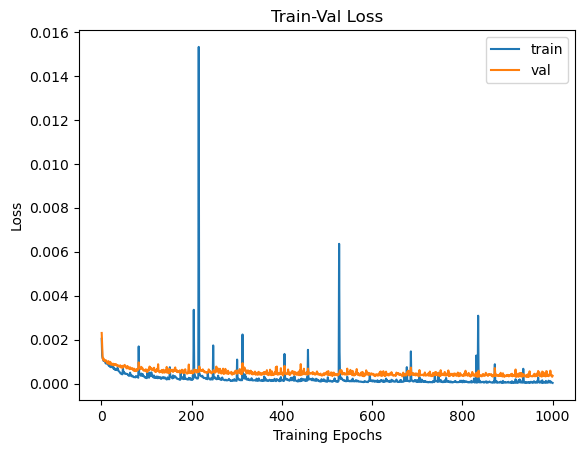

In [34]:
import matplotlib.pyplot as plt
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist_regression["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist_regression["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()